In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

# from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


## Load data and preprocess

In [2]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch spectra, only have '17-'19
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

################################

## Functions

In [3]:
def minorticks():
    plt.rcParams['xtick.bottom'] = True # keep my tick marks
    plt.rcParams['ytick.left'] = True
    
## function to get relevant distances and significant wave heights
def get_dist_hs(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index, where inside the ice edge
    dist = dist[index]
    hs = insitu_dict[insitu].sigwaveheight[index]
    dist = dist[~np.isnan(hs)] # exclude nans for hist2d plots
    hs = hs[~np.isnan(hs)]
    return dist,hs

def get_dist_period(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    period = insitu_dict[insitu].peakwaveperiod[index]
    dist = dist[~np.isnan(period)] # exclude nans for hist2d plots
    period = period[~np.isnan(period)]
    return dist,period

def get_dist_Te(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Te = insitu_dict[insitu].Te[index]
    dist = dist[~np.isnan(Te)] # exclude nans for hist2d plots
    Te = Te[~np.isnan(Te)]
    return dist,Te

def get_dist_Te_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Te = insitu_dict[insitu].Te[index]
    dist = dist[~np.isnan(Te)] # exclude nans for hist2d plots
    Te = Te[~np.isnan(Te)]
    return dist,Te

def get_dist_Tp_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    Tp = insitu_dict[insitu].peakwaveperiod[index]
    dist = dist[~np.isnan(Tp)] # exclude nans for hist2d plots
    Tp = Tp[~np.isnan(Tp)]
    return dist,Tp

def get_dist_hs_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    hs = insitu_dict[insitu].sigwaveheight[index]
    dist = dist[~np.isnan(hs)] # exclude nans for hist2d plots
    hs = hs[~np.isnan(hs)]
    return dist,hs

def get_wind_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    wind = insitu_dict[insitu].wind[index]
    dist = dist[~np.isnan(wind)] # exclude nans for hist2d plots
    wind = wind[~np.isnan(wind)] 
    return wind

def get_wind_dir_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    wind_dir = insitu_dict[insitu].wind_dir[index]
    dist = dist[~np.isnan(wind_dir)] # exclude nans for hist2d plots
    wind_dir = wind_dir[~np.isnan(wind_dir)] 
    return wind_dir

def get_peakdir_all(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index
    dist = dist[index]
    peakdir = insitu_dict[insitu].peakwavedirT[index]
    dist = dist[~np.isnan(peakdir)] # exclude nans for hist2d plots
    peakdir = peakdir[~np.isnan(peakdir)] 
    return peakdir

def get_dist_conc_hs(sat,insitu):
    dist = dist_dict[sat][insitu] # relies on distance dictionary
    index = np.where(dist >= 0)[0] # tuple index, where inside the ice edge
    dist = dist[index]
    hs = insitu_dict[insitu].sigwaveheight[index]
    conc = boot_cdr_interptoinsitu.sel(nj=nj[insitu]-300,ni=ni[insitu]).sel(time = dist.time)
    return dist,conc,hs

## sample code to find corresponding model cell to a latlon location
# templat = np.tile(sodaA.lat.values.mean(),
#                   cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
# templon = np.tile(sodaA.lon.values.mean(),
#                   cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
# difflat = templat - cice18.TLAT.values
# difflon = templon - cice18.TLON.values
# dist = difflat**2 + difflon**2
# np.where(dist == np.min(dist))

## Preprocessing

Resample in situ obs to 6-hour frequency (from 1 hour native frequency)

In [4]:
%%time

## resample
sodaA = sodaA.resample(time='6H').mean()
sodaB = sodaB.resample(time='6H').mean()
sodaC = sodaC.resample(time='6H').mean()
bgosA = bgosA.resample(time='6H').mean()
bgosD = bgosD.resample(time='6H').mean()

## exclude the nans
sodaA = sodaA.where(sodaA.sigwaveheight > 0, drop=True)
sodaB = sodaB.where(sodaB.sigwaveheight > 0, drop=True) 
sodaC = sodaC.where(sodaC.sigwaveheight > 0, drop=True) 
bgosA = bgosA.where(bgosA.sigwaveheight > 0, drop=True) 
bgosD = bgosD.where(bgosD.sigwaveheight > 0, drop=True) 

## repeat for swifts
for i,key in enumerate(swift_dict):
    swift_dict[key] = swift_dict[key].resample(time='6H').mean()
    swift_dict[key] = swift_dict[key].where(swift_dict[key].sigwaveheight > 0, drop=True)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 57.8 s, sys: 191 ms, total: 58 s
Wall time: 58.7 s


Interpolate distances to make one dataset that matches exactly the in situ obs timing.
Then create some dictionaries for ease of acccess.

In [5]:
%%time

alltimes = np.array([]) # make one array of all obs times
alltimes = np.hstack((bgosA.time.values,
                      bgosD.time.values,
#                       bds12.time.values, 
#                       bds15.time.values,
#                       bds17.time.values,
#                       bds18.time.values,
                      sodaA.time.values,
                      sodaB.time.values,
                      sodaC.time.values))

## add SWIFT data
for key,da in swift_dict.items():
    alltimes = np.hstack((alltimes,da.time.values))
    
alltimes = np.unique(np.sort(alltimes)) # times in ascending order, remove duplicates

## Uncomment this line when switching back to 6 hourly resample
dist_sat_interp = dist_sat_all.interp(time=alltimes)

###### also interpolate concentrations
time_forinterp = slice('2012-01-01','2019-12-31')

boot_cdr_interptoinsitu = boot.aice_d.sel(nj=latslice,time=time_forinterp).interp(time=alltimes)

CPU times: user 2.57 s, sys: 4.92 s, total: 7.49 s
Wall time: 16.3 s


In [13]:
## version with all obs, no resampling. 27 minutes!
# %%time
# dist_sat_interp = dist_sat_all.interp(time=alltimes)

CPU times: user 1min 11s, sys: 6min 24s, total: 7min 36s
Wall time: 27min 52s


In [37]:
## saved the version of in situ distances without resampling
# %%time
# new_filename = '~/scratch/waveice_analysis/dist_sat_interp_1hr.nc'
# print ('saving to ', new_filename)

# dist_sat_interp.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/dist_sat_interp_1hr.nc
finished saving
CPU times: user 311 ms, sys: 54.6 s, total: 54.9 s
Wall time: 3min 25s


In [11]:
## this is the 1 hour version; comment this out when using 6 hourly
# dist_sat_interp = xr.open_dataset('~/scratch/waveice_analysis/dist_sat_interp_1hr.nc')

In [6]:
%%time
## create dictionary of distances corresponding to obs
dist_dict = {}

cdr_dict = {}
cdr_dict['bgosA'] = dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).cdr
cdr_dict['bgosD'] = dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).cdr
cdr_dict['sodaA'] = dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).cdr
cdr_dict['sodaB'] = dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).cdr
cdr_dict['sodaC'] = dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).cdr

bt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).bt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).bt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).bt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).bt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).bt}

nt_dict = {
           'bgosA': dist_sat_interp.sel(nj=nj['bgosA']-300,ni=ni['bgosA'],time=bgosA.time).nt,
           'bgosD': dist_sat_interp.sel(nj=nj['bgosD']-300,ni=ni['bgosD'],time=bgosD.time).nt,
           'sodaA': dist_sat_interp.sel(nj=nj['sodaA']-300,ni=ni['sodaA'],time=sodaA.time).nt,
           'sodaB': dist_sat_interp.sel(nj=nj['sodaB']-300,ni=ni['sodaB'],time=sodaB.time).nt,
           'sodaC': dist_sat_interp.sel(nj=nj['sodaC']-300,ni=ni['sodaC'],time=sodaC.time).nt}

## optional addition of SWIFT data -- additional key for each buoy deployed
for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    
    ## insert the ice distances into the distance dictionaries
    cdr_dict[key] = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).cdr
    bt_dict[key]  = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).bt
    nt_dict[key]  = dist_sat_interp.sel(nj=njtemp-300,ni=nitemp,time=da.time).nt

dist_dict.update({'cdr' : cdr_dict,
                  'bt'  : bt_dict,
                  'nt'  : nt_dict})

# easy indexing of obs datasets
insitu_dict = {'sodaA' : sodaA,
               'sodaB' : sodaB,
               'sodaC' : sodaC,
               'bgosA' : bgosA,
               'bgosD' : bgosD,
              }

## SWIFT version already exists as swift_dict, but combine for ease with functions
for key,da in swift_dict.items():
    insitu_dict[key] = da

CPU times: user 408 ms, sys: 1.93 ms, total: 409 ms
Wall time: 421 ms


#### Add energy-weighted period to in situ data and wind (from JRA55 reanalysis)

##### Energy-weighted Period: $\frac{ \int f \cdot E(f)df}{ \int E(f)df}$

In [7]:
%%time

for key,val in insitu_dict.items():

    tempy = val.wavespectra_energy
    xfreq = val.freq_wavespectra.values
    
    tempy = tempy.where(tempy > 0, 0) # replace nans with zeros
    m0 = tempy.integrate(dim=tempy.dims[-1]) # area under spectral curve
    numerator = np.trapz(tempy * xfreq, xfreq)
    fe = numerator/m0 # energy weighted freq

    Te = 1./fe
    Te = Te.rename('Te')

    # also get the wind
    timekey = val.time.dt.round(freq='6H')
    uwnd = ww0019.uwnd.sel(ni=ni[key],nj=nj[key],time=timekey)
    vwnd = ww0019.vwnd.sel(ni=ni[key],nj=nj[key],time=timekey)
    wind = (np.sqrt(uwnd**2 + vwnd**2)).rename('wind')
    wind_dir = (np.arctan2(vwnd,uwnd)*180/np.pi).rename('wind_dir')
    
    wind['time'] = val.time.values
    wind_dir['time'] = val.time.values
    
    
    # let's add the CDR distance and concentration to the insitu dataset too to simplify things
    cdr = dist_dict['cdr'][key]
    
    # update xarray
    insitu_dict[key] = xr.merge([val,Te,wind,wind_dir,cdr])

CPU times: user 23.2 s, sys: 404 ms, total: 23.6 s
Wall time: 36.7 s


# Spectra without resampling to 6-hour frequency

### BGOS + SODA

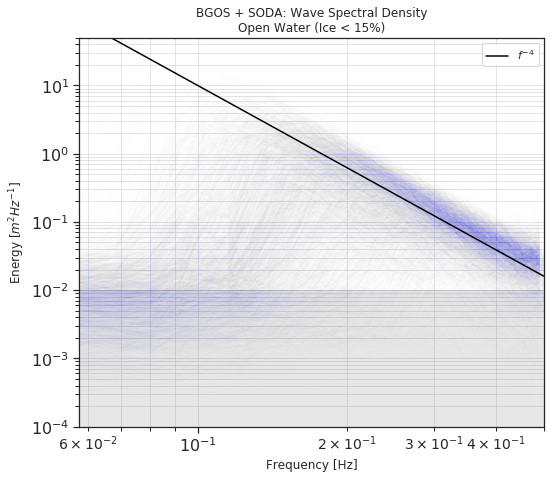

In [8]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.003,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


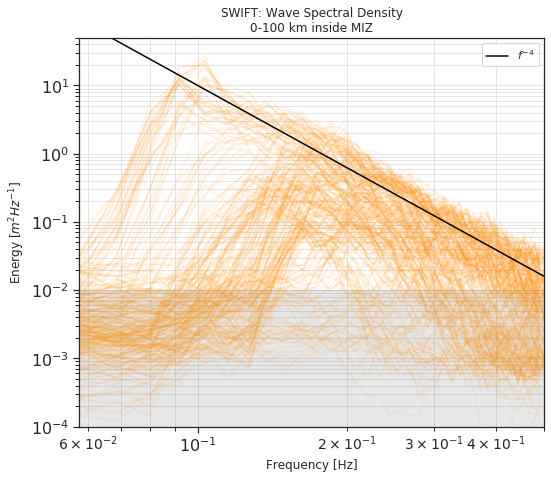

In [50]:
title = '0-100 km inside MIZ'
distmin = 0.0001
distmax = 100

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.1,add_legend=False,c='darkorange')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BOGS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


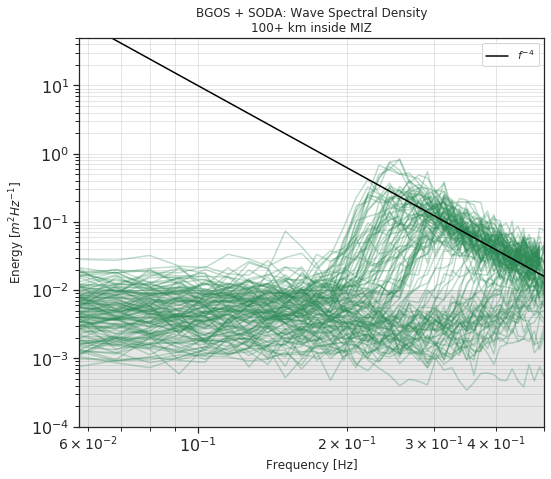

In [52]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.3,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

### SWIFT Data

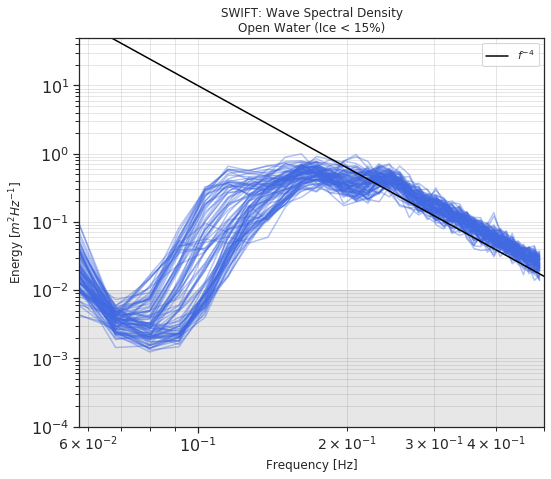

In [39]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

<xarray.DataArray 'time' (time: 5, freq_wavespectra: 42)>
array([[                          'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',                           'NaT',
                                  'NaT',              

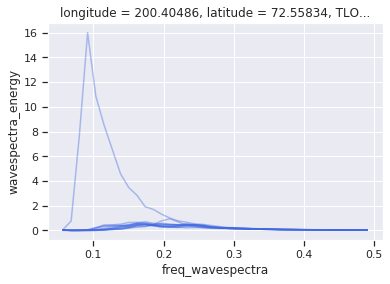

In [23]:
for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='royalblue')
            if spectrum.max() > 10:
                print(spectrum.time.where(spectrum > 10))
#                 print(spectrum.max())

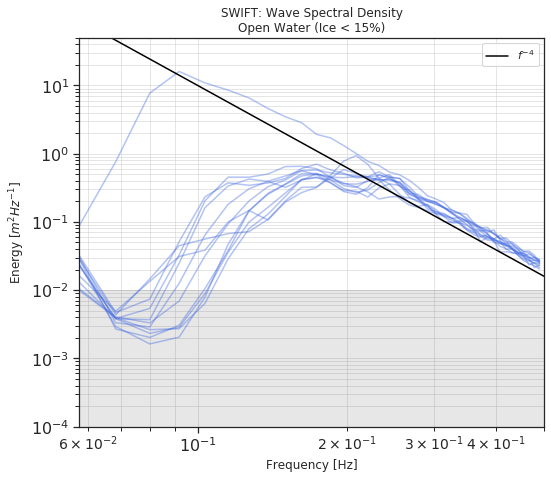

In [10]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

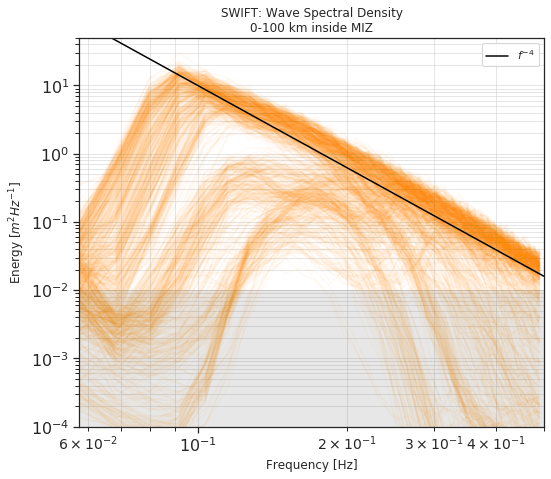

In [42]:
title = '0-100 km inside MIZ'
distmin = 0.0001
distmax = 100

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.04,add_legend=False,c='darkorange')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

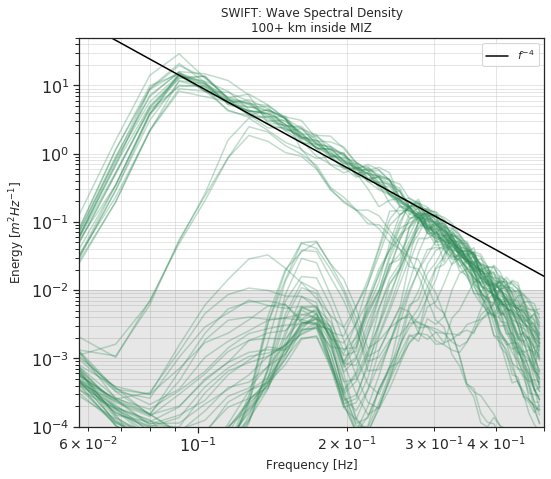

In [44]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] == 'SWIFT'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.2))

            spectrum.plot.line(
                        hue='time',alpha=0.3,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('SWIFT: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

## Spectra from Obs split by 6-8 melt and 10-11 grow

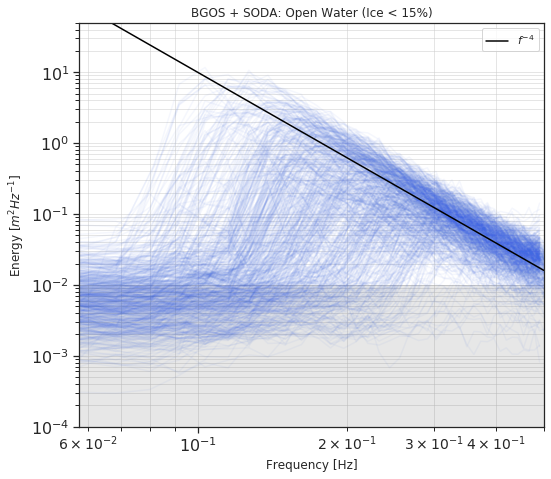

In [95]:
title = 'Open Water (Ice < 15%)'
distmin = -0.1
distmax = 0.0001
# monlist = np.array([10,11])
monlist = np.array([6,7,8])

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#             val = val.sel(time=val.time.dt.month.isin(monlist))
            spectrum = val.wavespectra_energy.where(
                (val.cdr > distmin) & 
                (val.cdr < distmax) & 
                (val.time.dt.month.isin(monlist)) & 
                (val.sigwaveheight > hsmin))

            spectrum.plot.line(
                        hue='time',alpha=0.05,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: ' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

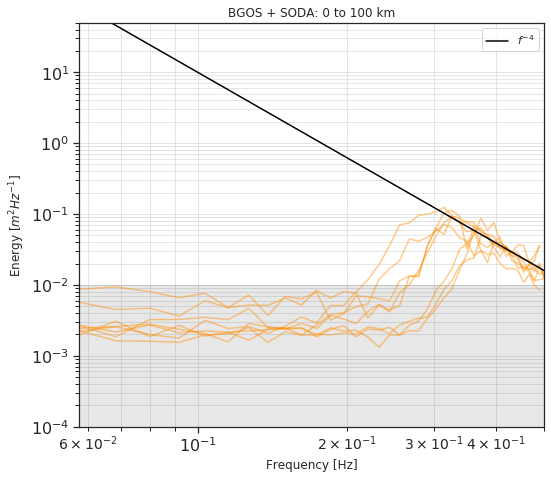

In [99]:
title = '0 to 100 km'
distmin = 0
distmax = 100
monlist = np.array([10,11])
monlist = np.array([6,7,8])

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#             val = val.sel(time=val.time.dt.month.isin(monlist))
            spectrum = val.wavespectra_energy.where(
                (val.cdr > distmin) & 
                (val.cdr < distmax) & 
                (val.time.dt.month.isin(monlist)) & 
                (val.sigwaveheight > hsmin))

            spectrum.plot.line(
                        hue='time',alpha=0.45,add_legend=False,c='darkorange')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: ' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

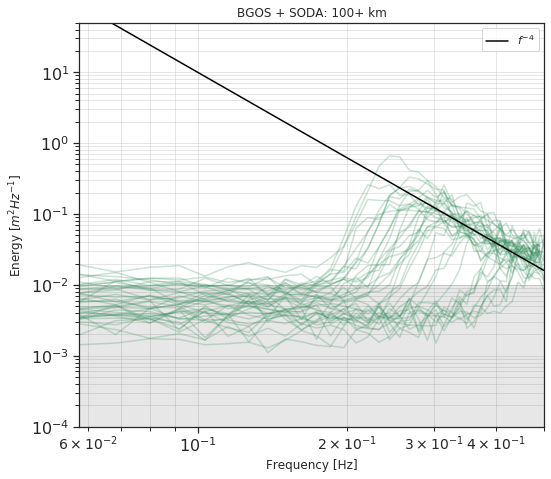

In [103]:
title = '100+ km'
distmin = 100
distmax = 1e4
# monlist = np.array([10,11])
monlist = np.array([6,7,8])

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#             val = val.sel(time=val.time.dt.month.isin(monlist))
            spectrum = val.wavespectra_energy.where(
                (val.cdr > distmin) & 
                (val.cdr < distmax) & 
                (val.time.dt.month.isin(monlist)) & 
                (val.sigwaveheight > hsmin))

            spectrum.plot.line(
                        hue='time',alpha=0.25,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: ' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax.xaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.show()

## Histogram of Significant Wave Height and Peak Period

In [8]:
## get the observations

month_limit = False
month_sel = 10
timeslice = slice('2012-01-01','2019-12-31')
# month_sel = 7 # choose true number of month (not python index at 0, so Jan = 1)
sat = 'cdr'

hs = np.array([])
fp = np.array([])
dist = np.array([])
hsmin = [] # dummy

hs_total = hs.copy() # array to hold all obs
fp_total = hs.copy() # array to hold all obs
dist_total = dist.copy() #  array to hold all obs

hs_threshold = 0.2

dist,hs = get_dist_hs(sat,'bgosA')
dist,fp = get_dist_period(sat,'bgosA')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'bgosD')
dist,fp = get_dist_period(sat,'bgosD')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaA')
dist,fp = get_dist_period(sat,'sodaA')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaB')
dist,fp = get_dist_period(sat,'sodaB')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

dist,hs = get_dist_hs(sat,'sodaC')
dist,fp = get_dist_period(sat,'sodaC')
fp = 1/fp # convert to peak freq
if month_limit:
    dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
    hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
    fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
hsmin = np.append(hsmin,np.min(hs))
print(hs.size,hsmin,hs[hs > hs_threshold].size)
hs_total = np.append(hs_total, hs)
fp_total = np.append(fp_total, fp)
dist_total = np.append(dist_total, dist)

## create separate totals
disttemp = dist_total[dist_total > 100]
hstemp = hs_total[dist_total > 100]
hstemp_0 = hs_total[dist_total < .0001]
hstemp_0to100 = hs_total[(dist_total < 100) & (dist_total > 0)]
hstemp_100less = hs_total[dist_total < 100]

fptemp = fp_total[dist_total > 100]
fptemp_0 = fp_total[dist_total < .0001]
fptemp_0to100 = fp_total[(dist_total < 100) & (dist_total > 0)]
hstemp_100less = hs_total[dist_total < 100]

975 [0.10253083] 955
441 [0.10253083 0.10044342] 412
449 [0.10253083 0.10044342 0.1117777 ] 423
180 [0.10253083 0.10044342 0.1117777  0.13309572] 169
16 [0.10253083 0.10044342 0.1117777  0.13309572 0.28915935] 16


In [9]:
def hs_fp_bymon(month_sel):
    ## get the observations

    month_limit = True
#     month_sel = 10
    timeslice = slice('2012-01-01','2019-12-31')
    # month_sel = 7 # choose true number of month (not python index at 0, so Jan = 1)
    sat = 'cdr'

    hs = np.array([])
    fp = np.array([])
    dist = np.array([])
    hsmin = [] # dummy

    hs_total = hs.copy() # array to hold all obs
    fp_total = hs.copy() # array to hold all obs
    dist_total = dist.copy() #  array to hold all obs

    hs_threshold = 0.2

    dist,hs = get_dist_hs(sat,'bgosA')
    dist,fp = get_dist_period(sat,'bgosA')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'bgosD')
    dist,fp = get_dist_period(sat,'bgosD')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaA')
    dist,fp = get_dist_period(sat,'sodaA')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaB')
    dist,fp = get_dist_period(sat,'sodaB')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    dist,hs = get_dist_hs(sat,'sodaC')
    dist,fp = get_dist_period(sat,'sodaC')
    fp = 1/fp # convert to peak freq
    if month_limit:
        dist = dist.where(pd.DatetimeIndex(dist.time.values).month == month_sel)
        hs = hs.where(pd.DatetimeIndex(hs.time.values).month == month_sel)
        fp = fp.where(pd.DatetimeIndex(fp.time.values).month == month_sel)
    hsmin = np.append(hsmin,np.min(hs))
    print(hs.size,hsmin,hs[hs > hs_threshold].size)
    hs_total = np.append(hs_total, hs)
    fp_total = np.append(fp_total, fp)
    dist_total = np.append(dist_total, dist)

    ## create separate totals
    hstemp = hs_total[dist_total > 100]
    hstemp_0 = hs_total[dist_total < .0001]
    hstemp_0to100 = hs_total[(dist_total < 100) & (dist_total > 0)]
    hstemp_100less = hs_total[dist_total < 100]

    fptemp = fp_total[dist_total > 100]
    fptemp_0 = fp_total[dist_total < .0001]
    fptemp_0to100 = fp_total[(dist_total < 100) & (dist_total > 0)]
    hstemp_100less = hs_total[dist_total < 100]
    
    return(hstemp_0,fptemp_0)

In [10]:
## group 6-8
obs_hs_melt_0 = np.array([])
obs_fp_melt_0 = np.array([])

temp1, temp2 = hs_fp_bymon(6);
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

temp1, temp2 = hs_fp_bymon(7);
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

temp1, temp2 = hs_fp_bymon(8);
obs_hs_melt_0 = np.append(obs_hs_melt_0,temp1)
obs_fp_melt_0 = np.append(obs_fp_melt_0,temp2)

########
## group 10 and 11
obs_hs_grow_0 = np.array([])
obs_fp_grow_0 = np.array([])

temp1, temp2 = hs_fp_bymon(10);
obs_hs_grow_0 = np.append(obs_hs_grow_0,temp1)
obs_fp_grow_0 = np.append(obs_fp_grow_0,temp2)

temp1, temp2 = hs_fp_bymon(11);
obs_hs_grow_0 = np.append(obs_hs_grow_0,temp1)
obs_fp_grow_0 = np.append(obs_fp_grow_0,temp2)

975 [0.41285881] 1
441 [0.41285881 0.10044342] 0
449 [0.41285881 0.10044342 0.15776753] 21
180 [0.41285881 0.10044342 0.15776753 0.20723106] 4
16 [0.41285881 0.10044342 0.15776753 0.20723106        nan] 0
975 [0.10253083] 19
441 [0.10253083 0.11050381] 2
449 [0.10253083 0.11050381 0.1201772 ] 107
180 [0.10253083 0.11050381 0.1201772  0.18323236] 0
16 [0.10253083 0.11050381 0.1201772  0.18323236 0.33248514] 7
975 [0.10754836] 277
441 [0.10754836 0.10126027] 113
449 [0.10754836 0.10126027 0.16282928] 122
180 [0.10754836 0.10126027 0.16282928 0.13309572] 66
16 [0.10754836 0.10126027 0.16282928 0.13309572 0.28915935] 8
975 [0.12612271] 249
441 [0.12612271 0.13390759] 89
449 [0.12612271 0.13390759 0.17300487] 61
180 [0.12612271 0.13390759 0.17300487 0.20713923] 51
16 [0.12612271 0.13390759 0.17300487 0.20713923        nan] 0
975 [1.7155475] 5
441 [1.7155475       nan] 0
449 [1.7155475       nan       nan] 0
180 [1.7155475       nan       nan       nan] 0
16 [1.7155475       nan       nan   

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in less
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in greater
/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less
/glade/work/vcooper/npl_clone02/lib/pyt

In [11]:
%%time

dist_plot = dist_model.sel(time=timeslice).where(
#     (dist_model.sel(time=timeslice) > 0) &
    (dist_model.sel(time=timeslice) > 100))

wave_plot_dist100 = xr.open_dataarray('./wave_plot_dist100.nc')
wave_plot_dist0 = xr.open_dataarray('~/scratch/waveice_analysis/wave_plot_dist0.nc')
wave_plot_dist0to100 = xr.open_dataarray('~/scratch/waveice_analysis/wave_plot_dist0to100.nc')
wave_plot_dist100less = xr.open_dataarray('./wave_plot_dist100less.nc')

freq_plot_dist100 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist100.nc')
freq_plot_dist0 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist0.nc')
freq_plot_dist0to100 = xr.open_dataarray('~/scratch/waveice_analysis/freq_plot_dist0to100.nc')

if month_limit:
    dist_plot = dist_plot[(
        pd.DatetimeIndex(dist_plot.time.values).month == month_sel)]
    wave_plot_dist100 = wave_plot_dist100[(
        pd.DatetimeIndex(wave_plot_dist100.time.values).month == month_sel)]
    wave_plot_dist100less = wave_plot_dist100less[(
        pd.DatetimeIndex(wave_plot_dist100less.time.values).month == month_sel)]
    freq_plot_dist100 = freq_plot_dist100[(
        pd.DatetimeIndex(freq_plot_dist100.time.values).month == month_sel)]
    
# this method gets rid of all the nans
x = dist_plot.values[wave_plot_dist100 > 0.1]
y = wave_plot_dist100.values[wave_plot_dist100 > 0.1]
y_fp = freq_plot_dist100.values[wave_plot_dist100 > 0.1]

## Beaufort Chukchi region
# right now this only gets distance over 100km
dist_plot_beau = dist_plot.where(beau_mask)
dist_plot_beau100plus = dist_plot_beau.where(dist_plot_beau > 100)

## RETAIN ORDER OF LINES
## peak frequencies
beau_fp = freq_plot_dist100.where(beau_mask)
beau_fp_0 = freq_plot_dist0.where(beau_mask)
beau_fp_0to100 = freq_plot_dist0to100.where(beau_mask)

## significant wave heights
ybeau = wave_plot_dist100.where(beau_mask)
beau_hs = wave_plot_dist100.where(beau_mask)
beau_hs_0 = wave_plot_dist0.where(beau_mask)
beau_hs_0to100 = wave_plot_dist0to100.where(beau_mask)

## distances and waveheights, get rid of nans
xbeau = dist_plot_beau.values[ybeau > 0.1]
ybeau = ybeau.values[ybeau > 0.1]

## get rid of nans
vbeau_fp = beau_fp.values[(beau_fp > 0) & (beau_hs > 0.1)]
vbeau_hs = beau_hs.values[(beau_fp > 0) & (beau_hs > 0.1)]

vbeau_fp_0 = beau_fp_0.values[(beau_fp_0 > 0) & (beau_hs_0 > 0.1)]
vbeau_hs_0 = beau_hs_0.values[(beau_fp_0 > 0) & (beau_hs_0 > 0.1)]

vbeau_fp_0to100 = beau_fp_0to100.values[(beau_fp_0to100 > 0) & (beau_hs_0to100 > 0.1)]
vbeau_hs_0to100 = beau_hs_0to100.values[(beau_fp_0to100 > 0) & (beau_hs_0to100 > 0.1)]

CPU times: user 6.7 s, sys: 14.4 s, total: 21.1 s
Wall time: 27.1 s


In [14]:
%%time
## create model array for Oct-Nov
hsmin = 0.2 ## version for era5 comparison
hsmin = 0.33 ## version for obs comparison
vbeau_fp_0_grow = np.array([])

ttemp = beau_fp_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 10) | (beau_fp_0.time.dt.month == 11)))
vbeau_fp_0_grow = ttemp.values[~np.isnan(ttemp)]

ttemp = beau_hs_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 10) | (beau_fp_0.time.dt.month == 11)))
vbeau_hs_0_grow = ttemp.values[~np.isnan(ttemp)]


## create model array for Jun-Jul-Aug
vbeau_fp_0_melt = np.array([])
ttemp = beau_fp_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 6) | 
                        (beau_fp_0.time.dt.month == 7) | 
                        (beau_fp_0.time.dt.month == 8)))
vbeau_fp_0_melt = ttemp.values[~np.isnan(ttemp)]

ttemp = beau_hs_0.where((beau_hs_0 > hsmin) & 
                       ((beau_fp_0.time.dt.month == 6) | 
                        (beau_fp_0.time.dt.month == 7) | 
                        (beau_fp_0.time.dt.month == 8)))
vbeau_hs_0_melt = ttemp.values[~np.isnan(ttemp)]

CPU times: user 3.83 s, sys: 2 s, total: 5.83 s
Wall time: 6.16 s


### Creating peak frequency files for model data (binned by ice distance)

In [67]:
# %%time
# ## create peak frequency file
# freq_plot_dist100 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) > 100))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist100.nc'
# print ('saving to ', new_filename)
# freq_plot_dist100.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.7 s, sys: 8.81 s, total: 55.5 s
Wall time: 1min 57s


In [69]:
# %%time
# freq_plot_dist0to100 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) < 100) & 
#     (dist_model.sel(time=timeslice) > 0))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist0to100.nc'
# print ('saving to ', new_filename)
# freq_plot_dist0to100.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.3 s, sys: 9.68 s, total: 56 s
Wall time: 1min 14s


In [71]:
# %%time
# freq_plot_dist0 = ww0019.fp.sel(nj=latslice,time=timeslice).where(
#     (ww0019.hs.sel(nj=latslice,time=timeslice) > 0.1) &
#     (dist_model.sel(time=timeslice) < 0.001))

# new_filename = '~/scratch/waveice_analysis/freq_plot_dist0.nc'
# print ('saving to ', new_filename)
# freq_plot_dist0.to_netcdf(path=new_filename)
# print ('finished saving')

CPU times: user 46.4 s, sys: 8.42 s, total: 54.9 s
Wall time: 1min 12s


In [36]:
# %%time
# wave_plot_dist0 = wave_plot_dist100less.where(dist_model.sel(time=timeslice) < 0.001)

# new_filename = '~/scratch/waveice_analysis/wave_plot_dist0.nc'
# print ('saving to ', new_filename)
# wave_plot_dist0.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/wave_plot_dist0.nc
finished saving
CPU times: user 618 ms, sys: 2.68 s, total: 3.29 s
Wall time: 7.74 s


In [37]:
# %%time
# wave_plot_dist0to100 = wave_plot_dist100less.where(dist_model.sel(time=timeslice) > 0)

# new_filename = '~/scratch/waveice_analysis/wave_plot_dist0to100.nc'
# print ('saving to ', new_filename)
# wave_plot_dist0to100.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ~/scratch/waveice_analysis/wave_plot_dist0to100.nc
finished saving
CPU times: user 588 ms, sys: 3.28 s, total: 3.86 s
Wall time: 9.56 s


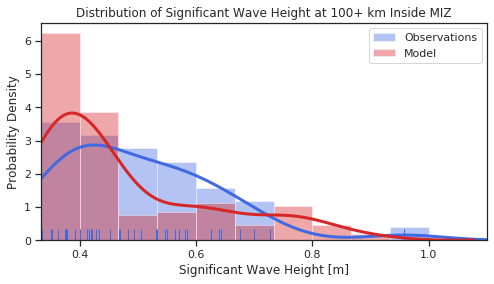

In [43]:
## post AGU, reduced model domain
## 1d histogram obs and model mixed
## BEAUFORT REGION
setmin = 0.3333333333
setmax = 1.0
nbins = 10
model_hs = vbeau_hs[vbeau_hs > setmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(hstemp[hstemp > setmin],bins=nbins,kde=True,rug=True,
                       color='royalblue',
                       label='Observations',
                       hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]})
    sns.distplot(model_hs,bins=nbins,kde=True,
                 color='tab:red',
                 label='Model',
                 hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Significant Wave Height at 100+ km Inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Significant Wave Height [m]')
    plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,1.1)
    plt.legend()

    plt.show()

(array([0.00131579, 0.00745614, 0.00307018, 0.0004386 , 0.0004386 ,
        0.00131579, 0.00219298, 0.        , 0.0004386 , 0.        ]),
 array([100., 160., 220., 280., 340., 400., 460., 520., 580., 640., 700.]),
 <a list of 10 Patch objects>)

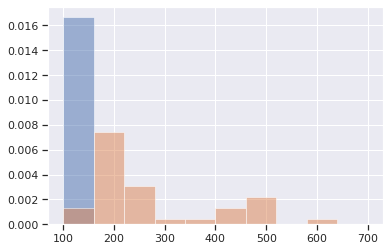

In [32]:
## distance histogram
plt.hist(xbeau_plot,alpha=0.5,range=[100,700],density=1)
plt.hist(disttemp[hstemp > hsmin],alpha=0.5,range=[100,700],density=1)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


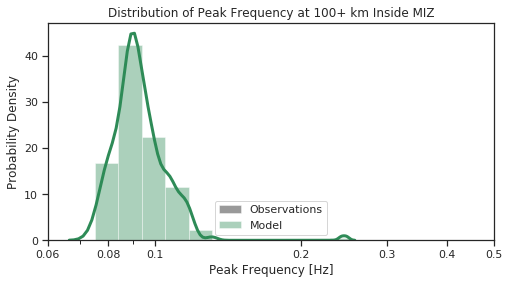

In [132]:
## 1d histogram obs and model
## BEAUFORT REGION
setmin = 6e-2
setmax = 0.5
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp[vbeau_hs > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp[hstemp>hsmin],bins=bins,kde=True,rug=True,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='seagreen',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency at 100+ km Inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

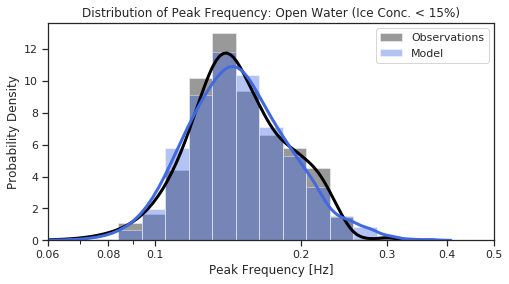

In [131]:
## 1d histogram obs and model
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0[vbeau_hs_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp_0[hstemp_0 > hsmin],bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

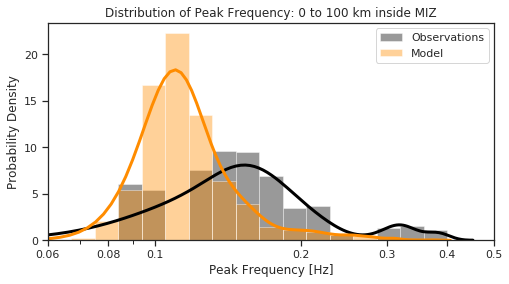

In [87]:
## 1d histogram obs and model
## peak frequency: 0 to 100
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0to100[vbeau_hs_0to100 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(fptemp_0to100[hstemp_0to100 > hsmin],bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='darkorange',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':0.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: 0 to 100 km inside MIZ')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

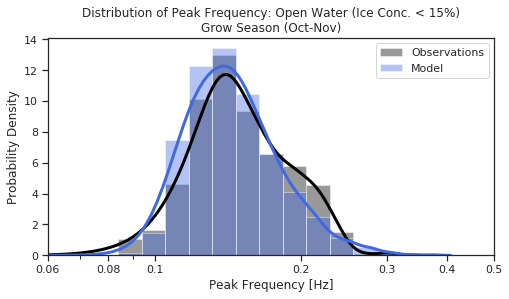

In [29]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_grow#[vbeau_hs_0_grow > hsmin]
obs_fp = obs_fp_grow_0[obs_hs_grow_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs_fp,bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nGrow Season (Oct-Nov)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

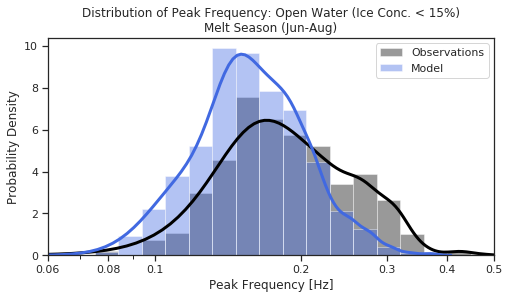

In [30]:
## melt season 6 7 8
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.33
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_melt
obs_fp = obs_fp_melt_0[obs_hs_melt_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs_fp,bins=bins,kde=True,rug=False,
                       color='k',
                       label='Observations',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':0.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nMelt Season (Jun-Aug)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

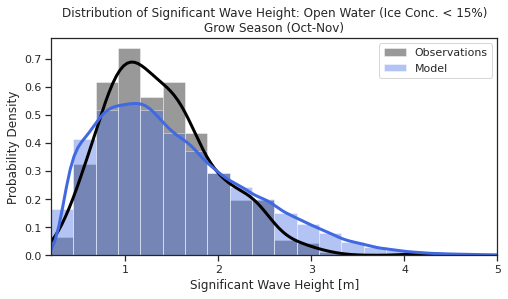

In [40]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 0.2
setmax = 5
hsmin = 0.33
nbins = 20
# bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model = vbeau_hs_0_grow#[vbeau_hs_0_grow > hsmin]
obs = obs_hs_grow_0[obs_hs_grow_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs,kde=True,rug=False,bins=nbins,
                       color='k',
                       label='Observations',
                       hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model,kde=True,bins=nbins,
                 color='royalblue',
                 label='Model',
                 hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Significant Wave Height: Open Water (Ice Conc. < 15%)\nGrow Season (Oct-Nov)')
    plt.ylabel('Probability Density')
    plt.xlabel('Significant Wave Height [m]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
#     plt.xscale('log')
#     plt.tick_params(axis='x', which='minor',labelsize=105)

#     xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
#     plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

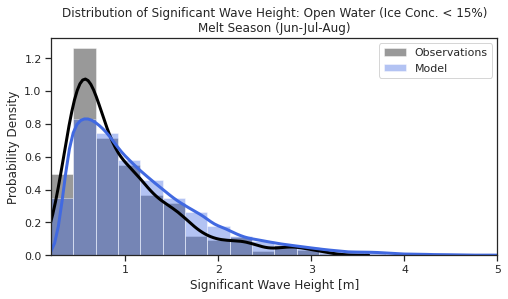

In [42]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 0.2
setmax = 5
hsmin = 0.33
nbins = 20
# bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model = vbeau_hs_0_melt#[vbeau_hs_0_grow > hsmin]
obs = obs_hs_melt_0[obs_hs_melt_0 > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs,kde=True,rug=False,bins=nbins,
                       color='k',
                       label='Observations',
                       hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model,kde=True,bins=nbins,
                 color='royalblue',
                 label='Model',
                 hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Significant Wave Height: Open Water (Ice Conc. < 15%)\nMelt Season (Jun-Jul-Aug)')
    plt.ylabel('Probability Density')
    plt.xlabel('Significant Wave Height [m]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
#     plt.xscale('log')
#     plt.tick_params(axis='x', which='minor',labelsize=105)

#     xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
#     plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

In [43]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 0.2
setmax = 5
hsmin = 0.33
nbins = 20
# bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model = vbeau_hs_melt#[vbeau_hs_0_grow > hsmin]
obs = obs_hs_melt[obs_hs_melt > hsmin]

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(obs,kde=True,rug=False,bins=nbins,
                       color='k',
                       label='Observations',
                       hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':'scott',
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model,kde=True,bins=nbins,
                 color='royalblue',
                 label='Model',
                 hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':'scott','label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Significant Wave Height: Open Water (Ice Conc. < 15%)\nMelt Season (Jun-Jul-Aug)')
    plt.ylabel('Probability Density')
    plt.xlabel('Significant Wave Height [m]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
#     plt.xscale('log')
#     plt.tick_params(axis='x', which='minor',labelsize=105)

#     xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
#     plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

NameError: name 'vbeau_hs_melt' is not defined

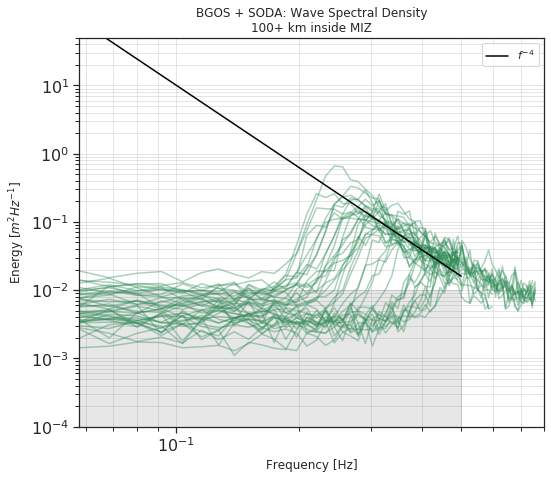

In [56]:
title = '100+ km inside MIZ'
distmin = 100
distmax = 1e5

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#         if (key[0] == 'b'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.33))

            spectrum.plot.line(
                        hue='time',alpha=0.4,add_legend=False,c='seagreen')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.xlim(10**(-1.24),0.8)
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

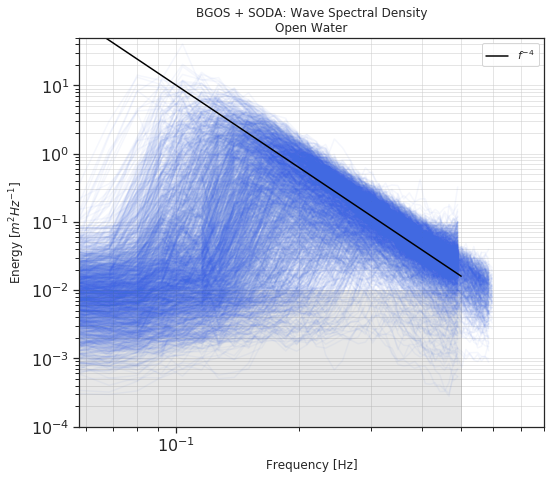

In [147]:
title = 'Open Water'
distmin = -1
distmax = 0.0001

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    for key,val in insitu_dict.items():
        if (key[0:5] != 'SWIFT'):
#         if (key[0] == 'b'):
            spectrum = val.wavespectra_energy.where(
                        (val.cdr > distmin) & 
                        (val.cdr < distmax) & 
                        (val.sigwaveheight > 0.33))

            spectrum.plot.line(
                        hue='time',alpha=0.05,add_legend=False,c='royalblue')

    ### dummy f^-4 line
    xtemp = np.linspace(6e-2,5e-1,100)
    Const = 10/(0.1**(-4)) ## position the line
    ytemp = xtemp**(-4) * Const
    plt.plot(xtemp,ytemp, label = '$f^{-4}$',c='k')
    
    ### NOISE FLOOR
    x = np.append([val.freq_wavespectra.values],0.5)
    nx = x.size
    yupper = np.tile(1*10**(-2),nx)
    ylower = np.tile(9*10**(-5),nx)
    ax.fill_between(x,ylower,yupper,alpha=0.1,color='0.1')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    
    ax.grid(True,which='both',alpha=0.5)
    plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.xlim(10**(-1.24),0.8)
    plt.ylim(10**(-4),5*10**(1))
    plt.title('BGOS + SODA: Wave Spectral Density\n' + title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]')#,fontsize='x-large')
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title('')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Model Spectra: open water only when waves are present

In [8]:
def spectral_plot_model(distmin,distmax):

    # select the Spectra
    spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > distmin) & 
        (ww1719beau_cat.dist < distmax) & 
        (ww1719beau_cat.hs > 0.2), 
        drop=True)

    # use numpy indexing to stack grid cells with time
    tempnp = (spectrum.stack(celltime=('time','nj','ni'))).values

    # get rid of all the spectral lines that are all nan (reduce data set)
    tempnp = tempnp[:,~np.all(np.isnan(tempnp[:]),axis=0)]

    # put back into xarray for plotting ease
    temp = xr.DataArray(
                tempnp,
                dims = ['f','celltime'],
                coords = {'f':spectrum.f})

    ## draw a maximum random sample of 10000 celltimes
    ## this reduces size for plotting
    celltime_index = np.random.choice(
        temp.celltime.values,
        size=np.min([10000,temp.celltime.values.size]),
        replace=False)

    return(temp[:,celltime_index])

## define additional function that only gets model spectra when there is swell inside the ice
def spectral_plot_model_limit100(distmin,distmax,hsmin):

    ## Find times when waves are present at 100 + km
    init_spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > 100) & 
        (ww1719beau_cat.hs > hsmin), 
        drop=True)

    ## subset the spectra by those times
    spectrum = ww1719ef_beau_cat.ef.where(ww1719ef_beau_cat.time == init_spectrum.time)
    
    spectrum = spectrum.where(
        (ww1719beau_cat.dist > distmin) & 
        (ww1719beau_cat.dist < distmax) & 
        (ww1719beau_cat.hs > hsmin), 
        drop=True)

    # use numpy indexing to stack grid cells with time
    tempnp = (spectrum.stack(celltime=('time','nj','ni'))).values

    # get rid of all the spectral lines that are all nan (reduce data set)
    tempnp = tempnp[:,~np.all(np.isnan(tempnp[:]),axis=0)]

    # put back into xarray for plotting ease
    temp = xr.DataArray(
                tempnp,
                dims = ['f','celltime'],
                coords = {'f':spectrum.f})

    ## draw a maximum random sample of 10000 celltimes
    ## this reduces size for plotting
    celltime_index = np.random.choice(
        temp.celltime.values,
        size=np.min([10000,temp.celltime.values.size]),
        replace=False)

    return(temp[:,celltime_index])

## monthly version
def spectral_plot_model_mon(distmin,distmax,hsmin,season):
    ## season is either 'melt' or 'grow'
    
    monlist = np.array([])
    if (season == 'melt'):
        monlist = np.array([6,7,8])
    elif (season == 'growth'):
        monlist = np.array([10,11])
    print(monlist)

    # select the Spectra
    spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > distmin) & 
        (ww1719beau_cat.dist < distmax) & 
        (ww1719beau_cat.hs > hsmin) & 
        (ww1719beau_cat.time.dt.month.isin(monlist)), 
        drop=True)

    # use numpy indexing to stack grid cells with time
    tempnp = (spectrum.stack(celltime=('time','nj','ni'))).values

    # get rid of all the spectral lines that are all nan (reduce data set)
    tempnp = tempnp[:,~np.all(np.isnan(tempnp[:]),axis=0)]

    # put back into xarray for plotting ease
    temp = xr.DataArray(
                tempnp,
                dims = ['f','celltime'],
                coords = {'f':spectrum.f})

    ## draw a maximum random sample of 10000 celltimes
    ## this reduces size for plotting
    celltime_index = np.random.choice(
        temp.celltime.values,
        size=np.min([10000,temp.celltime.values.size]),
        replace=False)

    return(temp[:,celltime_index])

In [10]:
init_spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > 100) & 
        (ww1719beau_cat.hs > 0.2), 
        drop=True)

In [18]:
init_spectrum.time.where(init_spectrum.time.dt.year != 2017, drop=True).values

array(['2018-11-05T12:00:00.000000000', '2018-11-05T18:00:00.000000000',
       '2018-11-06T00:00:00.000000000', '2019-10-30T12:00:00.000000000',
       '2019-11-27T06:00:00.000000000', '2019-11-29T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
%%time
distmin = -0.1
distmax = 0.0001
hsmin = 0.2

open_water_spectra = spectral_plot_model(distmin,distmax)
MIZto100_spectra = spectral_plot_model(0,100)
over100_spectra = spectral_plot_model(100,1e9)

## new version with only waves when we have waves at 100+
open_water_spectra_limit100 = spectral_plot_model_limit100(distmin,distmax,hsmin)
MIZto100_spectra_limit100 = spectral_plot_model_limit100(0,100,hsmin)
over100_spectra_limit100 = spectral_plot_model_limit100(100,1e9,hsmin)

## split into melt and growth
season = 'melt'
open_water_spectra_melt = spectral_plot_model_mon(distmin,distmax,hsmin,season)
MIZto100_spectra_melt = spectral_plot_model_mon(0,100,hsmin,season)
over100_spectra_melt = spectral_plot_model_mon(100,1e9,hsmin,season)

season = 'growth'
open_water_spectra_growth = spectral_plot_model_mon(distmin,distmax,hsmin,season)
MIZto100_spectra_growth = spectral_plot_model_mon(0,100,hsmin,season)
over100_spectra_growth = spectral_plot_model_mon(100,1e9,hsmin,season)

[6 7 8]
[6 7 8]
[6 7 8]
[10 11]
[10 11]
[10 11]
CPU times: user 1.3 s, sys: 623 ms, total: 1.92 s
Wall time: 2.09 s


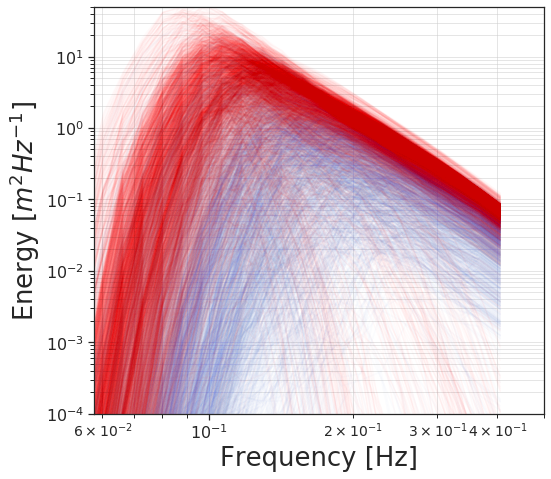

CPU times: user 5.39 s, sys: 35.2 ms, total: 5.42 s
Wall time: 5.41 s


In [143]:
%%time

title = 'Open Water (Ice Concentration < 15%)'
distmin=-0.1
distmax=0.1

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    open_water_spectra[:,0:2000].plot.line(
        hue='celltime',alpha=0.020,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')
    
    open_water_spectra_limit100.plot.line(
        hue='celltime',alpha=0.020,add_legend=False,
        xscale='log',yscale='log',
        c='r')
    
    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.01,add_legend=False,c='black')
    ########

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
#     plt.ylabel(' ',fontsize='x-large')
    
    plt.tight_layout()
    plt.show()

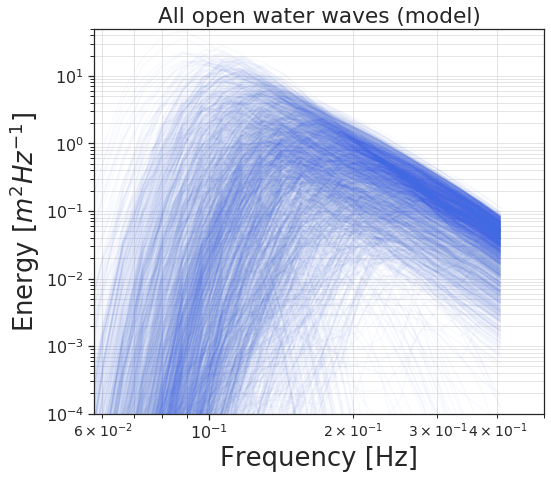

CPU times: user 2.68 s, sys: 20.3 ms, total: 2.7 s
Wall time: 2.69 s


In [56]:
%%time

title = 'Open Water (Ice Concentration < 15%)'
distmin=-0.1
distmax=0.1

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    open_water_spectra[:,0:2000].plot.line(
        hue='celltime',alpha=0.030,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')
    
    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.01,add_legend=False,c='black')
    ########

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('All open water waves (model)',fontsize='large')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
#     plt.ylabel(' ',fontsize='x-large')
    
    plt.tight_layout()
    plt.show()

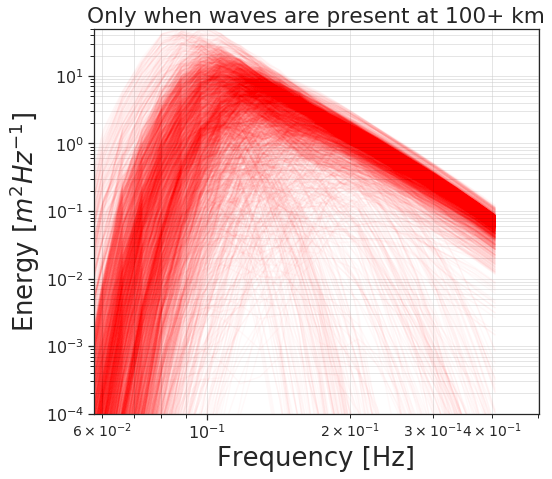

CPU times: user 3.27 s, sys: 6.54 ms, total: 3.28 s
Wall time: 3.28 s


In [148]:
%%time

title = 'Open Water (Ice Concentration < 15%)'
distmin=-0.1
distmax=0.1

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    open_water_spectra_limit100.plot.line(
        hue='celltime',alpha=0.025,add_legend=False,
        xscale='log',yscale='log',
        c='r')
    
    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.01,add_legend=False,c='black')
    ########

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Only when waves are present at 100+ km',fontsize='large')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
#     plt.ylabel(' ',fontsize='x-large')
    
    plt.tight_layout()
    plt.show()

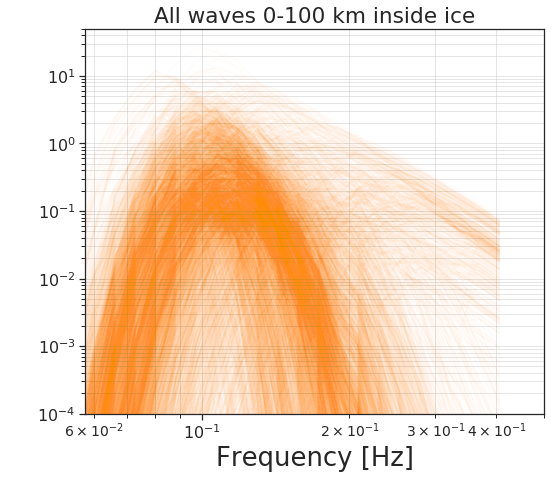

CPU times: user 4.32 s, sys: 21.5 ms, total: 4.34 s
Wall time: 4.35 s


In [61]:
%%time

title = '0 to 100 km Inside MIZ'
distmin=0
distmax=100


with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    MIZto100_spectra.plot.line(
        hue='celltime',alpha=0.018,add_legend=False,
        xscale='log',yscale='log',
        c='darkorange')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('All waves 0-100 km inside ice',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

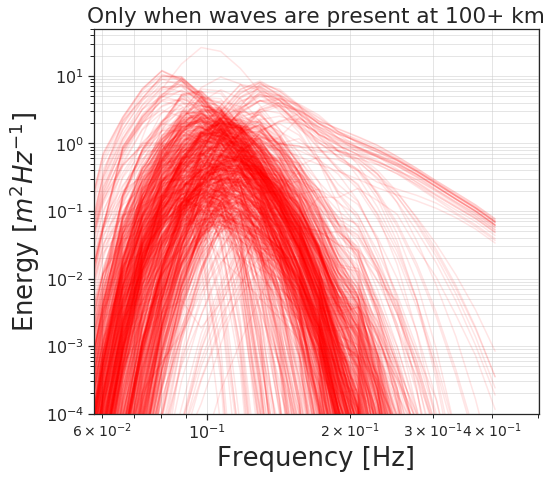

CPU times: user 1.39 s, sys: 8.76 ms, total: 1.4 s
Wall time: 1.4 s


In [147]:
%%time

title = 'Open Water (Ice Concentration < 15%)'
distmin=-0.1
distmax=0.1

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    MIZto100_spectra_limit100.plot.line(
        hue='celltime',alpha=0.100,add_legend=False,
        xscale='log',yscale='log',
        c='r')
    
    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.01,add_legend=False,c='black')
    ########

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Only when waves are present at 100+ km',fontsize='large')
    plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
#     plt.ylabel(' ',fontsize='x-large')
    
    plt.tight_layout()
    plt.show()

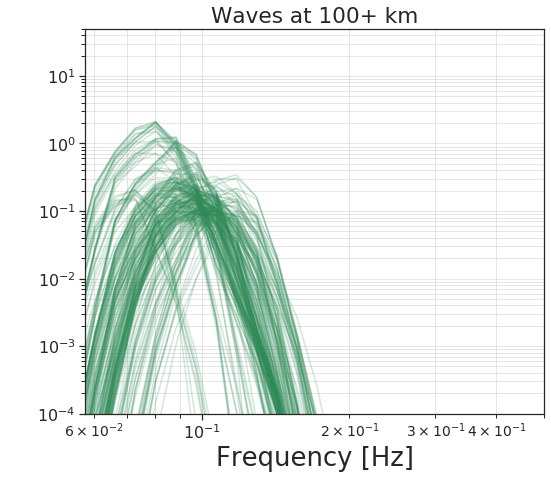

CPU times: user 870 ms, sys: 5.97 ms, total: 876 ms
Wall time: 898 ms


In [11]:
%%time

title = '100+ km Inside MIZ'

distmin=100
distmax=1e9

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    over100_spectra.plot.line(
        hue='celltime',alpha=0.210,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Waves at 100+ km',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

### Subset swell spectra to send to LAR, see how they fracture ice

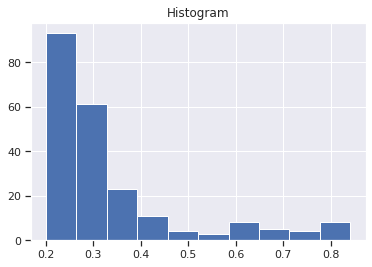

In [31]:
((over100_spectra.integrate(dim='f'))**(1/2)*4).plot.hist()
plt.show()

In [18]:
# over100_hs = over100_spectra.integrate(dim='f')
hs_sort = (over100_hs.sortby(over100_hs))**(1/2)*4

In [34]:
## sort spectra by Hs
over100_spectra_sorted = over100_spectra.sortby(over100_spectra.integrate(dim='f'))

In [47]:
indexlist = [int(220*0.5), int(220*0.75), int(220*0.9), -1]
over100_spectra_sorted[:,indexlist]
hs_sort[indexlist]

<xarray.DataArray (celltime: 4)>
array([0.28736025, 0.3573317 , 0.60056937, 0.84115994], dtype=float32)
Dimensions without coordinates: celltime

In [52]:
# over100_spectra_sorted[:,indexlist]

# new_filename = '/glade/campaign/univ/uwas0070/vcooper/waveice/filesharing/model_swell_over100_spectra.nc'
# print ('saving to ', new_filename)

# over100_spectra_sorted[:,indexlist].to_netcdf(path=new_filename)
# print ('finished saving')

saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/filesharing/model_swell_over100_spectra.nc
finished saving


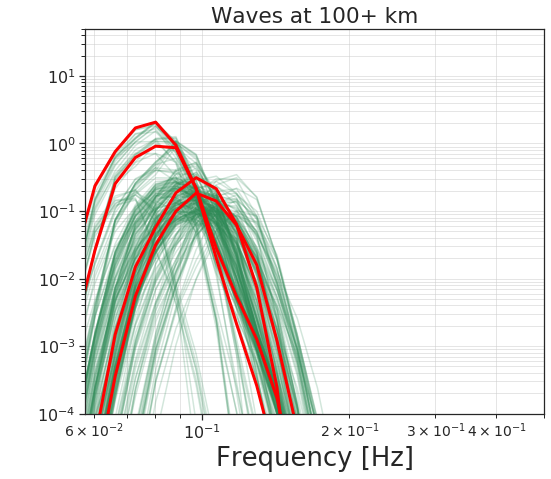

In [45]:
## plot with highlighted waves

title = '100+ km Inside MIZ'

distmin=100
distmax=1e9

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    over100_spectra.plot.line(
        hue='celltime',alpha=0.210,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')
    
    over100_spectra_sorted[:,-1].plot(
        xscale='log',yscale='log',c='r',lw=3)
    over100_spectra_sorted[:,int(220*0.5)].plot(
        xscale='log',yscale='log',c='r',lw=3)
    over100_spectra_sorted[:,int(220*0.75)].plot(
        xscale='log',yscale='log',c='r',lw=3)
    over100_spectra_sorted[:,int(220*0.9)].plot(
        xscale='log',yscale='log',c='r',lw=3)

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Waves at 100+ km',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

## Group model spectra by Melt / Grow

In [136]:
open_water_spectra_melt
open_water_spectra_growth

<xarray.DataArray (f: 25, celltime: 10000)>
array([[5.67904035e-09, 1.05991327e-10, 1.39020271e-11, ...,
        4.91511110e-10, 9.72982198e-12, 2.26662911e-09],
       [5.94507412e-08, 1.38688649e-09, 9.00817587e-10, ...,
        7.14473281e-09, 1.29949343e-10, 3.73099098e-08],
       [1.19242770e-07, 4.60637999e-08, 9.22482180e-09, ...,
        1.59638986e-08, 7.31279792e-09, 7.24691418e-08],
       ...,
       [1.48635998e-01, 1.80912718e-01, 2.59389460e-01, ...,
        5.64855151e-02, 8.56968481e-03, 7.36307949e-02],
       [9.66177434e-02, 1.18621886e-01, 1.72528088e-01, ...,
        3.89223583e-02, 5.31501183e-03, 4.91400994e-02],
       [5.99920079e-02, 7.36548677e-02, 1.07126355e-01, ...,
        2.41677109e-02, 3.30020278e-03, 3.05121243e-02]], dtype=float32)
Coordinates:
  * f        (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208
Dimensions without coordinates: celltime

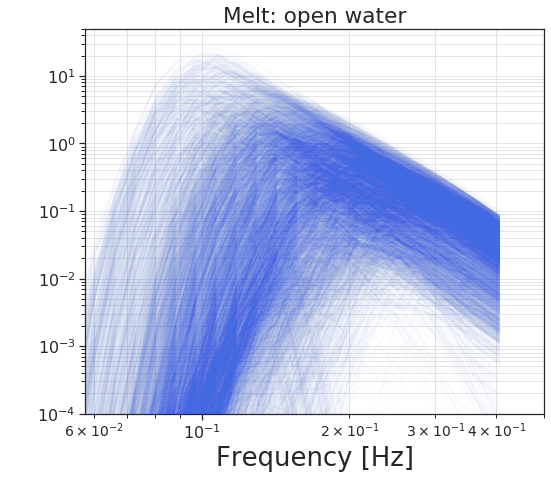

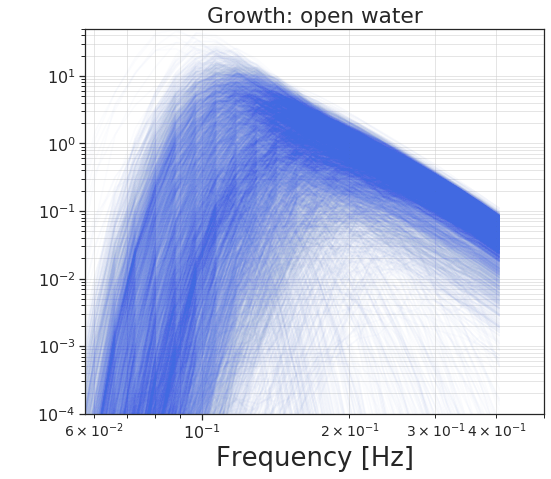

CPU times: user 11.3 s, sys: 33.3 ms, total: 11.4 s
Wall time: 11.4 s


In [149]:
%%time

title = 'Open Water'
distmin=-1
distmax=.0001


with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    open_water_spectra_melt[:,0:5000].plot.line(
        hue='celltime',alpha=0.02,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Melt: open water',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()
    

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    open_water_spectra_growth[:,0:5000].plot.line(
        hue='celltime',alpha=0.02,add_legend=False,
        xscale='log',yscale='log',
        c='royalblue')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Growth: open water',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

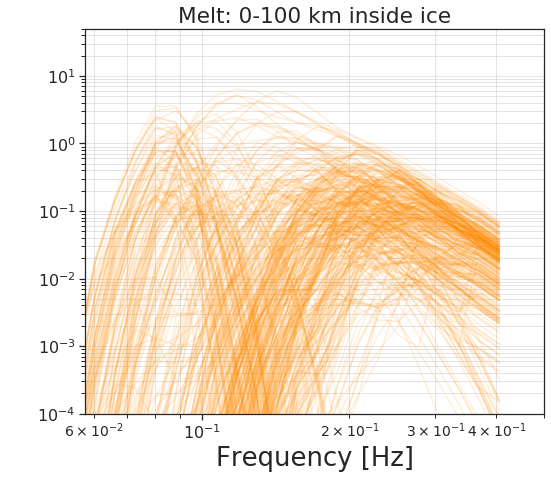

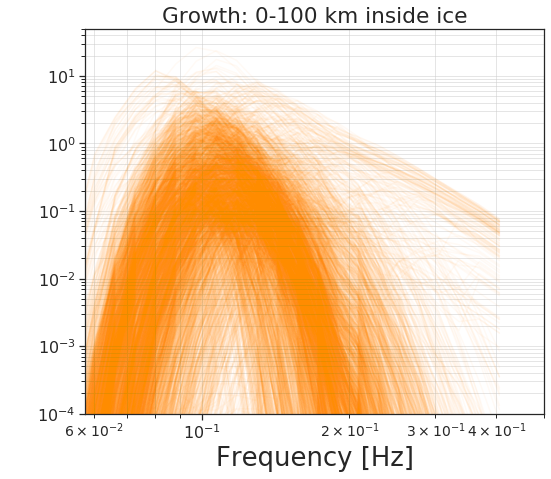

CPU times: user 4.41 s, sys: 26.6 ms, total: 4.43 s
Wall time: 4.45 s


In [150]:
%%time

title = '0 to 100 km Inside MIZ'
distmin=0
distmax=100


with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    MIZto100_spectra_melt.plot.line(
        hue='celltime',alpha=0.14,add_legend=False,
        xscale='log',yscale='log',
        c='darkorange')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Melt: 0-100 km inside ice',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()
    

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    MIZto100_spectra_growth.plot.line(
        hue='celltime',alpha=0.04,add_legend=False,
        xscale='log',yscale='log',
        c='darkorange')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Growth: 0-100 km inside ice',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

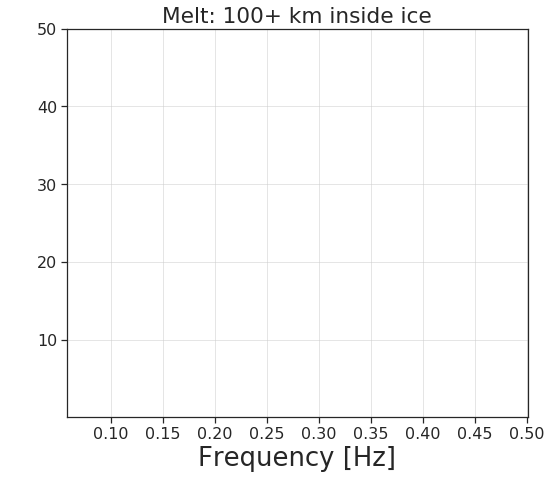

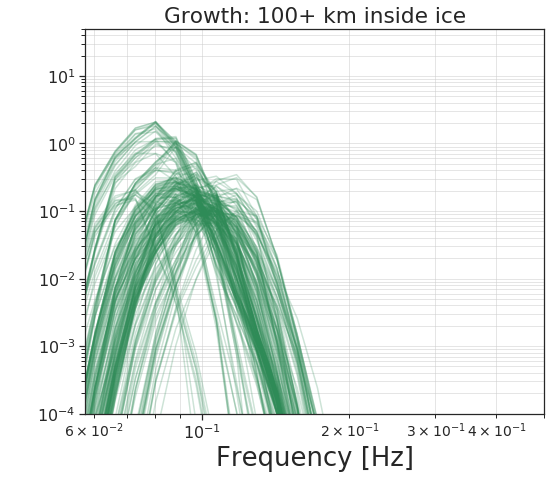

CPU times: user 958 ms, sys: 7.79 ms, total: 966 ms
Wall time: 963 ms


In [151]:
%%time

title = '100+ km Inside MIZ'
distmin=100
distmax=1e4


with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
#     over100_spectra_melt.plot.line(
#         hue='celltime',alpha=0.34,add_legend=False,
#         xscale='log',yscale='log',
#         c='seagreen')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Melt: 100+ km inside ice',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()
    

with sns.axes_style('white'):
    minorticks()
    fig,ax = plt.subplots(figsize=(8,7))
    
    over100_spectra_growth.plot.line(
        hue='celltime',alpha=0.24,add_legend=False,
        xscale='log',yscale='log',
        c='seagreen')

    ####### OBS
#     for key,val in insitu_dict.items():
#         spectrum = val.wavespectra_energy.where(
#                     (val.cdr > distmin) & 
#                     (val.cdr < distmax) & 
#                     (val.sigwaveheight > 0.1))

#         spectrum[:,4:].plot.line(
#                     hue='time',alpha=0.2,add_legend=False,c='black')
    ########
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    ax.grid(True,which='both',alpha=0.5)
#     plt.loglog()
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.xlabel('Frequency [Hz]',fontsize='x-large')
#     plt.title('Model: Wave Spectral Density\n' + title)
    plt.title('Growth: 100+ km inside ice',fontsize='large')
#     plt.ylabel('Energy [$m^2 Hz^{-1}$]',fontsize='x-large')
    plt.ylabel(' ',fontsize='x-large')

    plt.tight_layout()
    plt.show()

# Peak wave direction from model at 100+ km inside ice edge

In [92]:
## scratch to make model climo of wave direction
distmin = 100
distmax = 1e4

distmin = 0
distmax = 100

# distmin = -1
# distmax = 0.00001

hsmin = 0.2

init_spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > 100) & 
        (ww1719beau_cat.hs > hsmin), 
        drop=True)

## subset the spectra by those times
spectrum = ww1719ef_beau_cat.ef.where(ww1719ef_beau_cat.time == init_spectrum.time)

spectrum = spectrum.where(
    (ww1719beau_cat.dist > distmin) & 
    (ww1719beau_cat.dist < distmax) & 
    (ww1719beau_cat.hs > hsmin), 
    drop=False)

direction = ww1719beau_cat.dir.where(spectrum.max(dim='f') > 0,drop=True)
hs_direction = ww1719beau_cat.hs.where(spectrum.max(dim='f') > 0,drop=True)

## eliminate nans, format numpy arrays for wind rose
dir_np = direction.values.ravel()
dir_np = dir_np[~np.isnan(dir_np)]

hs_np = hs_direction.values.ravel()
hs_np = hs_np[~np.isnan(hs_np)]

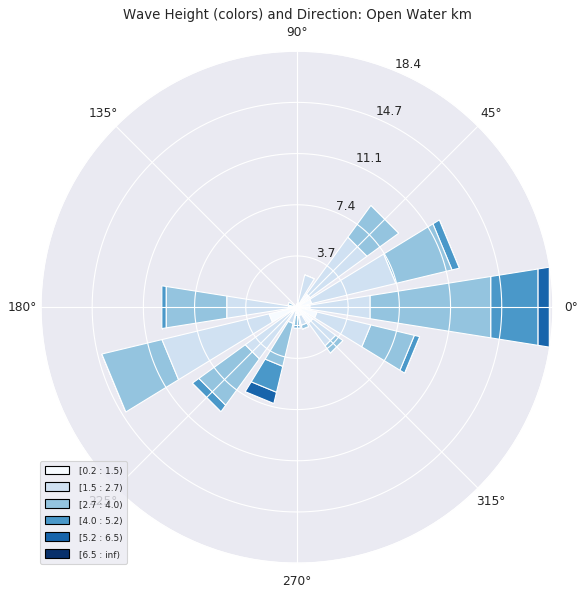

In [91]:
## open water
ax = WindroseAxes.from_ax()
ax.bar(dir_np,hs_np,
       normed=True,opening=0.8,edgecolor='white',cmap=mpl.cm.Blues)#,
#        bins=np.linspace(0,9,8))
ax.set_legend()
plt.title('Wave Height (colors) and Direction: Open Water')
plt.show()

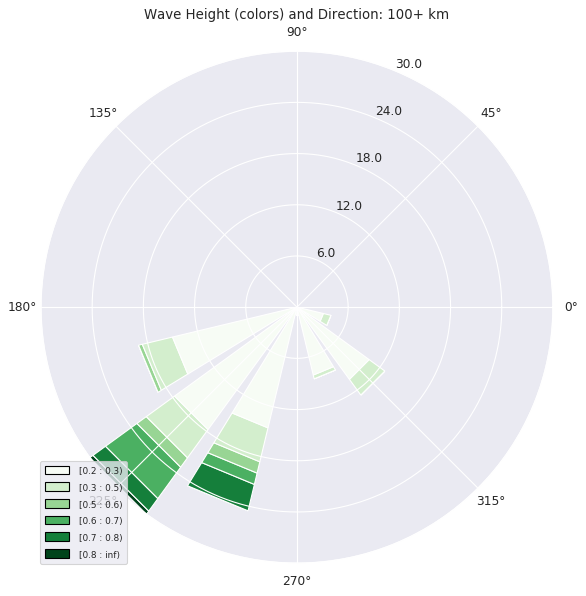

In [72]:
ax = WindroseAxes.from_ax()
ax.bar(dir_np,hs_np,
       normed=True,opening=0.8,edgecolor='white',cmap=mpl.cm.Greens)#,
#        bins=np.linspace(0,9,8))
ax.set_legend()
plt.title('Wave Height (colors) and Direction: 100+ km')
plt.show()

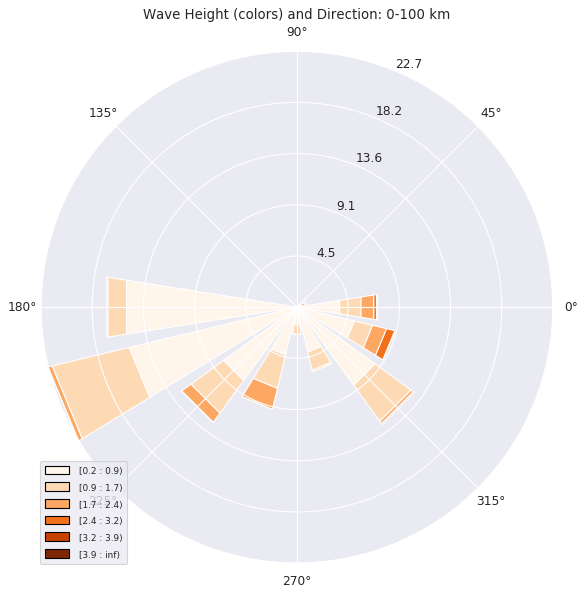

In [94]:
## 0 - 100 km
ax = WindroseAxes.from_ax()
ax.bar(dir_np,hs_np,
       normed=True,opening=0.8,edgecolor='white',cmap=mpl.cm.Oranges)#,
#        bins=np.linspace(0,9,8))
ax.set_legend()
plt.title('Wave Height (colors) and Direction: 0-100 km')
plt.show()

## ERA-5 data adjustment

In [134]:
varlist = ['10m_u_component_of_wind.nc',
 '10m_v_component_of_wind.nc',
 'sea_ice_cover.nc',
 'significant_height_of_combined_wind_waves_and_swell.nc',
 'significant_height_of_wind_waves.nc',
 'significant_height_of_total_swell.nc',
 'peak_wave_period.nc',
 'mean_period_of_wind_waves.nc',
 'mean_wave_direction.nc']
varlist_short = ['significant_height_of_wind_waves.nc',
 'significant_height_of_total_swell.nc',
 'peak_wave_period.nc',
 'mean_period_of_wind_waves.nc',
 'mean_wave_direction.nc']

In [138]:
for var in varlist_short:
    print(var)
    vartemp = var
    fpath01 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '01' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath02 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '02' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath03 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '03' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath04 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '04' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath05 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '05' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath06 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '06' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath07 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '07' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath08 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '08' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath09 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '09' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath10 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '10' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath11 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '11' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    fpath12 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '12' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
    tempera01 = xr.open_dataset(fpath01)
    tempera02 = xr.open_dataset(fpath02)
    tempera03 = xr.open_dataset(fpath03)
    tempera04 = xr.open_dataset(fpath04)
    tempera05 = xr.open_dataset(fpath05)
    tempera06 = xr.open_dataset(fpath06)
    tempera07 = xr.open_dataset(fpath07)
    tempera08 = xr.open_dataset(fpath08)
    tempera09 = xr.open_dataset(fpath09)
    tempera10 = xr.open_dataset(fpath10)
    tempera11 = xr.open_dataset(fpath11)
    tempera12 = xr.open_dataset(fpath12)

    tempera = xr.merge([tempera01,
                        tempera02,
                       tempera03,
                       tempera04,
                       tempera05,
                       tempera06,
                       tempera07,
                       tempera08,
                       tempera09,
                       tempera10,
                       tempera11,
                       tempera12])

    ## repeat for 2017 to 2019
    fpath01 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '01' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath02 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '02' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath03 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '03' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath04 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '04' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath05 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '05' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath06 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '06' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath07 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '07' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath08 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '08' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath09 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '09' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath10 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '10' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath11 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '11' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    fpath12 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '12' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
    tempera01 = xr.open_dataset(fpath01)
    tempera02 = xr.open_dataset(fpath02)
    tempera03 = xr.open_dataset(fpath03)
    tempera04 = xr.open_dataset(fpath04)
    tempera05 = xr.open_dataset(fpath05)
    tempera06 = xr.open_dataset(fpath06)
    tempera07 = xr.open_dataset(fpath07)
    tempera08 = xr.open_dataset(fpath08)
    tempera09 = xr.open_dataset(fpath09)
    tempera10 = xr.open_dataset(fpath10)
    tempera11 = xr.open_dataset(fpath11)
    tempera12 = xr.open_dataset(fpath12)

    tempera1719 = xr.merge([tempera01,
                        tempera02,
                       tempera03,
                       tempera04,
                       tempera05,
                       tempera06,
                       tempera07,
                       tempera08,
                       tempera09,
                       tempera10,
                       tempera11,
                       tempera12])

    tempera_all = xr.merge([tempera,tempera1719])
    
    new_filename = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_var' + vartemp
    print ('saving to ', new_filename)

    tempera_all.to_netcdf(path=new_filename)
    print ('finished saving')
print('Done')

significant_height_of_wind_waves.nc
saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varsignificant_height_of_wind_waves.nc
finished saving
significant_height_of_total_swell.nc
saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varsignificant_height_of_total_swell.nc
finished saving
peak_wave_period.nc
saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varpeak_wave_period.nc
finished saving
mean_period_of_wind_waves.nc
saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varmean_period_of_wind_waves.nc
finished saving
mean_wave_direction.nc
saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varmean_wave_direction.nc
finished saving
Done


In [135]:
%%time
vartemp = 'significant_height_of_combined_wind_waves_and_swell.nc'
fpath01 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '01' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath02 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '02' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath03 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '03' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath04 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '04' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath05 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '05' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath06 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '06' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath07 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '07' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath08 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '08' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath09 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '09' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath10 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '10' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath11 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '11' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
fpath12 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '12' + '_years=2014to2016_minlat=60_grid=0.5x0.5' + vartemp
tempera01 = xr.open_dataset(fpath01)
tempera02 = xr.open_dataset(fpath02)
tempera03 = xr.open_dataset(fpath03)
tempera04 = xr.open_dataset(fpath04)
tempera05 = xr.open_dataset(fpath05)
tempera06 = xr.open_dataset(fpath06)
tempera07 = xr.open_dataset(fpath07)
tempera08 = xr.open_dataset(fpath08)
tempera09 = xr.open_dataset(fpath09)
tempera10 = xr.open_dataset(fpath10)
tempera11 = xr.open_dataset(fpath11)
tempera12 = xr.open_dataset(fpath12)

tempera = xr.merge([tempera01,
                    tempera02,
                   tempera03,
                   tempera04,
                   tempera05,
                   tempera06,
                   tempera07,
                   tempera08,
                   tempera09,
                   tempera10,
                   tempera11,
                   tempera12])

## repeat for 2017 to 2019
fpath01 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '01' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath02 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '02' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath03 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '03' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath04 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '04' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath05 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '05' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath06 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '06' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath07 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '07' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath08 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '08' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath09 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '09' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath10 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '10' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath11 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '11' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
fpath12 = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months='+ '12' + '_years=2017to2019_minlat=60_grid=0.5x0.5' + vartemp
tempera01 = xr.open_dataset(fpath01)
tempera02 = xr.open_dataset(fpath02)
tempera03 = xr.open_dataset(fpath03)
tempera04 = xr.open_dataset(fpath04)
tempera05 = xr.open_dataset(fpath05)
tempera06 = xr.open_dataset(fpath06)
tempera07 = xr.open_dataset(fpath07)
tempera08 = xr.open_dataset(fpath08)
tempera09 = xr.open_dataset(fpath09)
tempera10 = xr.open_dataset(fpath10)
tempera11 = xr.open_dataset(fpath11)
tempera12 = xr.open_dataset(fpath12)

tempera1719 = xr.merge([tempera01,
                    tempera02,
                   tempera03,
                   tempera04,
                   tempera05,
                   tempera06,
                   tempera07,
                   tempera08,
                   tempera09,
                   tempera10,
                   tempera11,
                   tempera12])

tempera_all = xr.merge([tempera,tempera1719])

# tempera02 = xr.open_dataset('/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/months=02_years=2014to2016_minlat=60_grid=0.5x0.510m_u_component_of_wind.nc')

CPU times: user 41.8 s, sys: 28.1 s, total: 1min 9s
Wall time: 1min 12s


In [136]:
new_filename = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_var' + vartemp
print ('saving to ', new_filename)

tempera_all.to_netcdf(path=new_filename)
print ('finished saving')

saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_varsignificant_height_of_combined_wind_waves_and_swell.nc
finished saving


In [139]:
## combine all into one file
temp_era = xr.open_mfdataset('/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014*.nc')
#                              concat_dim="time",data_vars='minimal', coords='minimal', compat='override')
temp_era.load()

In [143]:
# %%time
# new_filename = '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_var_all.nc'
# print ('saving to ', new_filename)

# temp_era.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  /glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_var_all.nc
finished saving
CPU times: user 28.5 ms, sys: 4.06 s, total: 4.09 s
Wall time: 4.59 s


# ERA-5 spatial comparson

In [121]:
era5cice = xr.open_dataset(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/cice_grid/2014-2019_minlat60_grid0.5x0.5_var_all_ciceregrid.nc')

era5native = xr.open_dataset(
    '/glade/campaign/univ/uwas0070/vcooper/waveice/era5/native/concat/2014-2019_minlat60_grid0.5x0.5_var_all.nc')


### Check Regridding

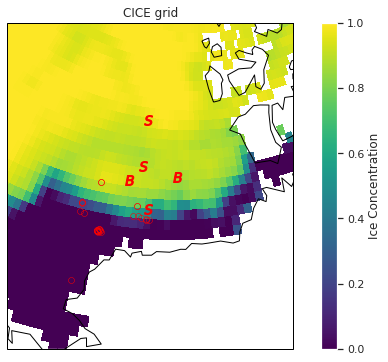

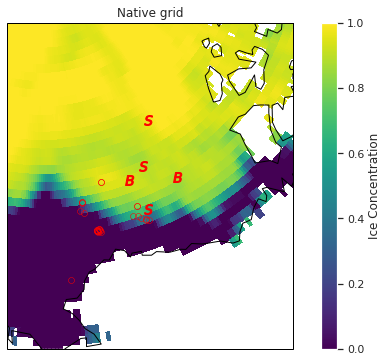

In [65]:
fig = plt.subplots(figsize=(10,6))
proj = ccrs.NorthPolarStereo(central_longitude=190-360)
timeslice=slice('2017-11-04','2017-11-04')
msel = 11

## select concentration data
cicegrid_plot = era5cice.siconc.sel(time=timeslice).where(
    (era5cice.time.dt.month == msel),drop=True).mean(dim='time')

## select distance data
nativegrid_plot = era5native.siconc.sel(time=timeslice).where(
    (era5native.time.dt.month == msel),drop=True).mean(dim='time')

ax = plt.subplot(projection=proj)
# ax.set_extent([-175,-147,64,82])
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## concentration colormesh
cicegrid_plot.plot.pcolormesh(
    'TLON','TLAT',cbar_kwargs={'label':'Ice Concentration'},
#     cmap=cmap,vmax=1,vmin=0.15,#shading='gouraud',
    ax=ax,transform=ccrs.PlateCarree())

# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


# ax.add_feature(cfeature.LAND,zorder=2)
# ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])

plt.title('CICE grid')
# plt.title('Model\nJuly 2017-2019 Daily Mean')

# plt.title('Satellite (NSIDC Climate Data Record)\n21 Nov. 2019')
# plt.title('Model\n21 Nov. 2019')

# plt.legend(loc='upper left')
# plt.tight_layout()
plt.show()

########################################################################
fig = plt.subplots(figsize=(10,6))

ax = plt.subplot(projection=proj)
# ax.set_extent([-175,-147,64,82])
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## concentration colormesh
nativegrid_plot.plot.pcolormesh(
    'longitude','latitude',cbar_kwargs={'label':'Ice Concentration'},
#     cmap=cmap,vmax=1,vmin=0.15,#shading='gouraud',
    ax=ax,transform=ccrs.PlateCarree())

# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


# ax.add_feature(cfeature.LAND,zorder=2)
# ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])

plt.title('Native grid')
# plt.title('Model\nJuly 2017-2019 Daily Mean')

# plt.title('Satellite (NSIDC Climate Data Record)\n21 Nov. 2019')
# plt.title('Model\n21 Nov. 2019')

# plt.legend(loc='upper left')
# plt.tight_layout()
plt.show()

## Compare peak period vs. ERA-5: melt vs growth season

In [71]:
era5cice.pp1d

<xarray.DataArray 'pp1d' (time: 8764, nj: 384, ni: 320)>
[1076920320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2019-12-31T18:00:00
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  Peak wave period
    units:      s

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'lw'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'lw'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


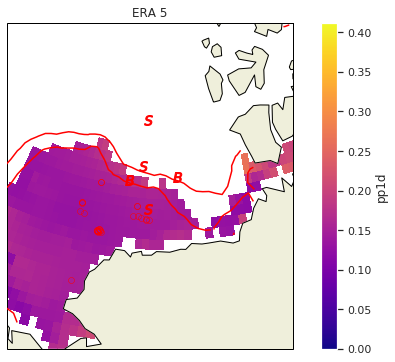

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'lw'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'lw'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


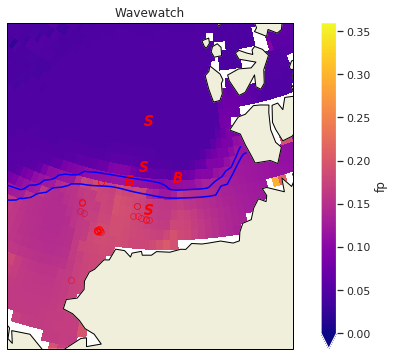

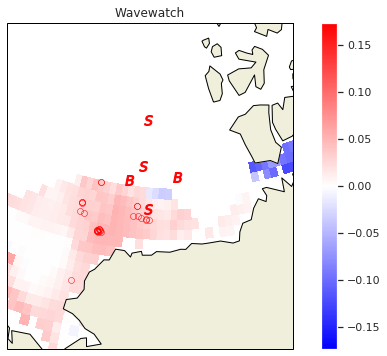

In [122]:
fig = plt.subplots(figsize=(10,6))
proj = ccrs.NorthPolarStereo(central_longitude=190-360)
timeslice=slice('2019-11-02','2019-11-02')
msel = 11

## select plotting data
era5_plot = (era5cice.pp1d**(-1)).sel(time=timeslice).where(
    (era5cice.time.dt.month == msel),drop=True).mean(dim='time')

ww_plot = ww1719beau.fp.sel(time=timeslice).where(
    (era5native.time.dt.month == msel),drop=True).mean(dim='time')

## add concentration contours
era5_ice = (era5cice.siconc).sel(time=timeslice).where(
    (era5cice.time.dt.month == msel),drop=True).mean(dim='time')

ww_ice = ww1719beau.ice.sel(time=timeslice).where(
    (era5native.time.dt.month == msel),drop=True).mean(dim='time')

ax = plt.subplot(projection=proj)
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## colormesh
era5_plot.plot.pcolormesh(
    'TLON','TLAT',
    cmap='plasma',vmin=0,
    ax=ax,transform=ccrs.PlateCarree())

## concentration contour
contourp = era5_ice.where(era5_ice.TLON > 180).plot.contour(
    'TLON','TLAT',
    levels=[0.15,0.80],
    lw=2,
    linestyles = ['-'],#,'-','-','-','-'],
#     add_colorbar=True,
#     colors=['r','r']#,'k','k','k','k'],
    colors='r',
    ax=ax,transform=ccrs.PlateCarree(),zorder=6)
contourp = era5_ice.where(era5_ice.TLON < 180).plot.contour(
    'TLON','TLAT',
    levels=[0.15,0.80],
    lw=2,
    linestyles = ['-'],#,'-','-','-','-'],
#     add_colorbar=True,
#     colors=['r','r']#,'k','k','k','k'],
    colors='r',
    ax=ax,transform=ccrs.PlateCarree(),zorder=6)


# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND,zorder=2)

plt.title('ERA 5')
plt.show()

########################################################################
fig = plt.subplots(figsize=(10,6))

ax = plt.subplot(projection=proj)
# ax.set_extent([-175,-147,64,82])
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## concentration colormesh
ww_plot.plot.pcolormesh(
    'longitude','latitude',
    cmap='plasma',vmin=0,
    ax=ax,transform=ccrs.PlateCarree())

## concentration contour
contourp = ww_ice.where(ww_ice.longitude > 180).plot.contour(
    'longitude','latitude',
    levels=[0.15,0.80],
    lw=2,
    linestyles = ['-'],#,'-','-','-','-'],
#     add_colorbar=True,
#     colors=['r','r']#,'k','k','k','k'],
    colors='b',
    ax=ax,transform=ccrs.PlateCarree(),zorder=6)
contourp = ww_ice.where(ww_ice.longitude < 180).plot.contour(
    'longitude','latitude',
    levels=[0.15,0.80],
    lw=2,
    linestyles = ['-'],#,'-','-','-','-'],
#     add_colorbar=True,
#     colors=['r','r']#,'k','k','k','k'],
    colors='b',
    ax=ax,transform=ccrs.PlateCarree(),zorder=6)

# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND,zorder=2)
# ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])

plt.title('Wavewatch')

plt.show()

########################################################################
## differences
fig = plt.subplots(figsize=(10,6))

ax = plt.subplot(projection=proj)
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## dummy boolean to only show differences when both models are in open water
ice_boolean = ww_ice.where(ww_ice < 0.15) * era5_ice.where(era5_ice < 0.15).sel(nj=latslice)
ice_boolean = (ice_boolean+1)/(ice_boolean+1)

(ww_plot - era5_plot.sel(nj=latslice) * ice_boolean).plot.pcolormesh(
    'longitude','latitude',
    cmap='bwr',
    ax=ax,transform=ccrs.PlateCarree())

# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND,zorder=2)
# ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])

plt.title('Wavewatch')

plt.show()

In [156]:
## get the times I want to compare
## use a few of the model swell times
## and a few of the obs wind wave times?

init_spectrum = ww1719ef_beau_cat.ef.where(
        (ww1719beau_cat.dist > 100) & 
        (ww1719beau_cat.hs > 0.2), 
        drop=True)
init_spectrum.time.values

array(['2017-10-14T00:00:00.000000000', '2017-10-14T06:00:00.000000000',
       '2017-10-14T12:00:00.000000000', '2017-10-20T18:00:00.000000000',
       '2017-10-21T00:00:00.000000000', '2017-10-21T06:00:00.000000000',
       '2017-10-21T12:00:00.000000000', '2017-10-21T18:00:00.000000000',
       '2017-10-22T00:00:00.000000000', '2017-10-22T06:00:00.000000000',
       '2017-10-22T12:00:00.000000000', '2017-10-28T06:00:00.000000000',
       '2017-10-28T12:00:00.000000000', '2017-10-28T18:00:00.000000000',
       '2017-11-03T12:00:00.000000000', '2017-11-03T18:00:00.000000000',
       '2017-11-04T00:00:00.000000000', '2017-11-04T06:00:00.000000000',
       '2017-11-04T12:00:00.000000000', '2017-11-07T18:00:00.000000000',
       '2017-11-08T00:00:00.000000000', '2017-11-08T06:00:00.000000000',
       '2017-11-08T12:00:00.000000000', '2017-11-08T18:00:00.000000000',
       '2017-11-09T00:00:00.000000000', '2017-11-09T06:00:00.000000000',
       '2017-11-09T12:00:00.000000000', '2017-11-09

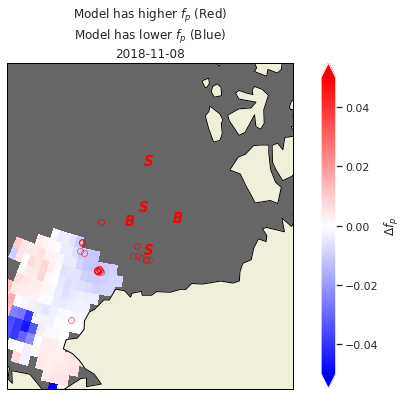

In [205]:
timeslice=slice('2018-11-08T11','2018-11-08T13')
msel = 11
date_title = era5cice.pp1d.sel(time=timeslice)[0].time.values.astype(str)[0:10]

## select plotting data
era5_plot = (era5cice.pp1d.sel(time=timeslice).where(
    (era5cice.time.dt.month == msel),drop=True)**(-1)).mean(dim='time')

ww_plot = ww1719beau.fp.sel(time=timeslice).where(
    (era5native.time.dt.month == msel),drop=True).mean(dim='time')

## add concentration contours
era5_ice = (era5cice.siconc).sel(time=timeslice).where(
    (era5cice.time.dt.month == msel),drop=True).mean(dim='time')

ww_ice = ww1719beau.ice.sel(time=timeslice).where(
    (era5native.time.dt.month == msel),drop=True).mean(dim='time')

########################################################################
## differences
fig = plt.subplots(figsize=(10,6))
proj = ccrs.NorthPolarStereo(central_longitude=190-360)

ax = plt.subplot(projection=proj)
ax.set_extent([-175,-132,66,84])
ax.coastlines(zorder=5)

## dummy boolean to only show differences when both models are in open water
ice_boolean = ww_ice.where(ww_ice < 0.15) * era5_ice.where(era5_ice < 0.15).sel(nj=latslice)
ice_boolean = (ice_boolean+1)/(ice_boolean+1)

diffplot = (ww_plot - era5_plot.sel(nj=latslice).where(ice_boolean > 0)).plot.pcolormesh(
    'longitude','latitude',
    cmap='bwr',vmin=-0.05,vmax=0.05,
    ax=ax,transform=ccrs.PlateCarree())

diffplot.colorbar.set_label('$\Delta f_p$')


# ice_boolean.where()

# BGEP
ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
        transform=ccrs.PlateCarree())
ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
        transform=ccrs.PlateCarree())

# SODA
ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
        transform=ccrs.PlateCarree())
ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())
ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
        transform=ccrs.PlateCarree())

for key,da in swift_dict.items():
    ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
        transform=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND,zorder=2)
ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])
ax.add_feature(cfeature.OCEAN,zorder=0,color='0.4')

plt.title('Model has higher $f_p$ (Red)\n' + 
          'Model has lower $f_p$ (Blue)\n' + date_title)

plt.show()

In [211]:
def era5compare_fp(timeslice,msel):
#     timeslice=slice('2018-11-08T11','2018-11-08T13')
#     msel = 11
    date_title = era5cice.pp1d.sel(time=timeslice)[0].time.values.astype(str)[0:10]

    ## select plotting data
    era5_plot = (era5cice.pp1d.sel(time=timeslice).where(
        (era5cice.time.dt.month == msel),drop=True)**(-1)).mean(dim='time')

    ww_plot = ww1719beau.fp.sel(time=timeslice).where(
        (era5native.time.dt.month == msel),drop=True).mean(dim='time')

    ## add concentration contours
    era5_ice = (era5cice.siconc).sel(time=timeslice).where(
        (era5cice.time.dt.month == msel),drop=True).mean(dim='time')

    ww_ice = ww1719beau.ice.sel(time=timeslice).where(
        (era5native.time.dt.month == msel),drop=True).mean(dim='time')

    ########################################################################
    ## differences
    fig = plt.subplots(figsize=(10,6))
    proj = ccrs.NorthPolarStereo(central_longitude=190-360)

    ax = plt.subplot(projection=proj)
    ax.set_extent([-175,-132,66,84])
    ax.coastlines(zorder=5)

    ## dummy boolean to only show differences when both models are in open water
    ice_boolean = ww_ice.where(ww_ice < 0.15) * era5_ice.where(era5_ice < 0.15).sel(nj=latslice)
    ice_boolean = (ice_boolean+1)/(ice_boolean+1)

    diffplot = (ww_plot - era5_plot.sel(nj=latslice).where(ice_boolean > 0)).plot.pcolormesh(
        'longitude','latitude',
        cmap='bwr',vmin=-0.1,vmax=0.1,
        ax=ax,transform=ccrs.PlateCarree())

    diffplot.colorbar.set_label('$\Delta f_p$ [Hz]')


    # ice_boolean.where()

    # BGEP
    ax.plot(210,75,marker='$B$',c='r',markersize=10,linewidth=0,label='BGOS',
            transform=ccrs.PlateCarree())
    ax.plot(220,74,marker='$B$',c='r',markersize=10,linewidth=0,label='',
            transform=ccrs.PlateCarree())

    # SODA
    ax.plot(211.66,73.00,marker='$S$',c='r',markersize=10,linewidth=0,label='SODA',
            transform=ccrs.PlateCarree())
    ax.plot(214.36,75.46,marker='$S$',c='r',markersize=10,
            transform=ccrs.PlateCarree())
    ax.plot(220.86,77.74,marker='$S$',c='r',markersize=10,
            transform=ccrs.PlateCarree())

    for key,da in swift_dict.items():
        ax.plot(da.lon.mean(),da.lat.mean(),marker='o',mec='r',mfc='none',markersize=6,mew=0.5,
            transform=ccrs.PlateCarree())


    ax.add_feature(cfeature.LAND,zorder=2)
    ax.add_feature(cfeature.OCEAN,zorder=0,color=cfeature.COLORS['land'])
    ax.add_feature(cfeature.OCEAN,zorder=0,color='0.4')

    plt.title('Model has higher $f_p$ (Red)\n' + 
              'Model has lower $f_p$ (Blue)\n' + date_title)

    plt.show()

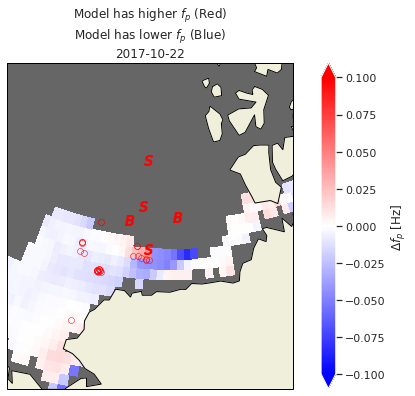

In [214]:
tslice2 = slice('2017-10-22T05','2017-10-22T07')
era5compare_fp(tslice2,10)

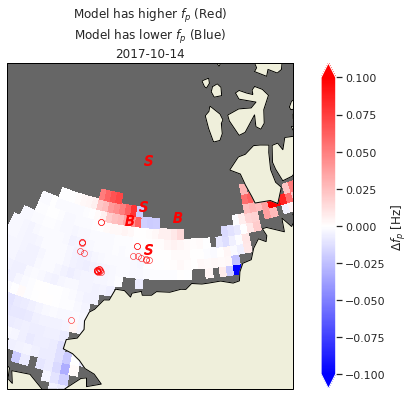

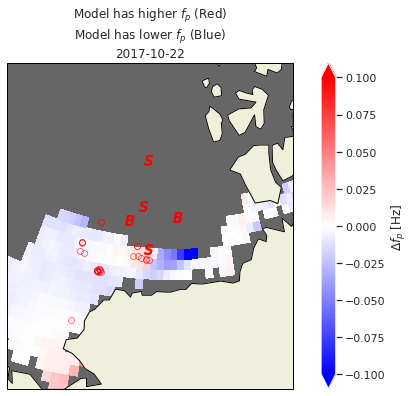

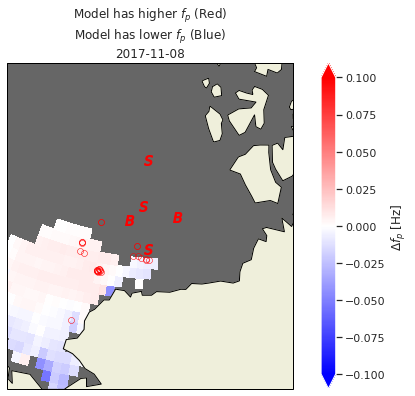

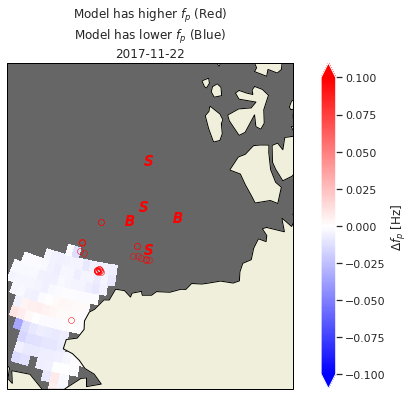

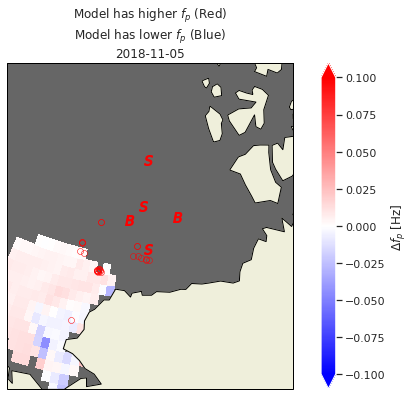

In [225]:
tslice2 = slice('2017-10-14T05','2017-10-14T07')
era5compare_fp(tslice2,10)

tslice2 = slice('2017-10-22T11','2017-10-22T13')
era5compare_fp(tslice2,10)

tslice2 = slice('2017-11-08T11','2017-11-08T13')
era5compare_fp(tslice2,11)

tslice2 = slice('2017-11-22T11','2017-11-22T13')
era5compare_fp(tslice2,11)

tslice2 = slice('2018-11-05T15','2018-11-05T19')
era5compare_fp(tslice2,11)

In [213]:
init_spectrum.time.values

array(['2017-10-14T00:00:00.000000000', '2017-10-14T06:00:00.000000000',
       '2017-10-14T12:00:00.000000000', '2017-10-20T18:00:00.000000000',
       '2017-10-21T00:00:00.000000000', '2017-10-21T06:00:00.000000000',
       '2017-10-21T12:00:00.000000000', '2017-10-21T18:00:00.000000000',
       '2017-10-22T00:00:00.000000000', '2017-10-22T06:00:00.000000000',
       '2017-10-22T12:00:00.000000000', '2017-10-28T06:00:00.000000000',
       '2017-10-28T12:00:00.000000000', '2017-10-28T18:00:00.000000000',
       '2017-11-03T12:00:00.000000000', '2017-11-03T18:00:00.000000000',
       '2017-11-04T00:00:00.000000000', '2017-11-04T06:00:00.000000000',
       '2017-11-04T12:00:00.000000000', '2017-11-07T18:00:00.000000000',
       '2017-11-08T00:00:00.000000000', '2017-11-08T06:00:00.000000000',
       '2017-11-08T12:00:00.000000000', '2017-11-08T18:00:00.000000000',
       '2017-11-09T00:00:00.000000000', '2017-11-09T06:00:00.000000000',
       '2017-11-09T12:00:00.000000000', '2017-11-09

### ERA-5 comparison using histogram of peak frequency

In [130]:
%%time
## subset era5cice
era5_beau_m = era5cice.sel(nj=latslice).where(
    (era5cice.time.dt.month == 10) | (era5cice.time.dt.month == 11),drop=True).where(
    beau_mask > 0,drop=True)

era5_fp_beau = era5_beau_m.pp1d.where((era5_beau_m.swh > 0.2) & 
                                      (era5_beau_m.siconc < 0.15),drop=True)
era5_fp_beau = era5_fp_beau**(-1)

era5_fp_beau_np = era5_fp_beau.values[~np.isnan(era5_fp_beau)]

CPU times: user 2.26 s, sys: 2.21 s, total: 4.47 s
Wall time: 10.7 s


<xarray.DataArray 'pp1d' (time: 1196, nj: 12, ni: 32)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2014-10-01 ... 2019-11-30T18:00:00
    TLON       (nj, ni) float32 186.961 188.27522 ... 232.68097 233.6385
    TLAT       (nj, ni) float32 73.28595 73.16747 ... 74.299866 74.10803
    longitude  (nj, ni) float32 186.961 188.27522 ... 232.68097 233.6385
    latitude   (nj, ni) float32 73.28595 73.16747 ... 74.299866 74.10803
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  Peak wave period
    units:      s

In [149]:
%%time
## subset era5cice
era5_beau_m = era5cice.sel(nj=latslice).where(
    (era5cice.time.dt.month == 6) | 
    (era5cice.time.dt.month == 7) | 
    (era5cice.time.dt.month == 8),drop=True).where(
    beau_mask > 0,drop=True)

era5_fp_beau = era5_beau_m.pp1d.where((era5_beau_m.swh > 0.2) & 
                                      (era5_beau_m.siconc < 0.15),drop=True)
era5_fp_beau = era5_fp_beau**(-1)

era5_fp_beau_np_melt = era5_fp_beau.values[~np.isnan(era5_fp_beau)]

CPU times: user 11.7 s, sys: 1min 6s, total: 1min 18s
Wall time: 1min 43s


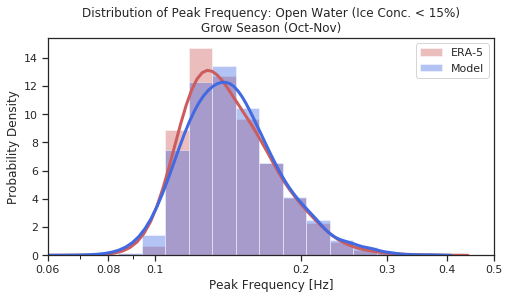

In [148]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.2
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_grow#[vbeau_hs_0_grow > hsmin]
era5_fp = era5_fp_beau_np ## beware this already has 0.2 min Hs 

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(era5_fp,bins=bins,kde=True,rug=False,
                       color='indianred',
                       label='ERA-5',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':0.01,
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nGrow Season (Oct-Nov)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

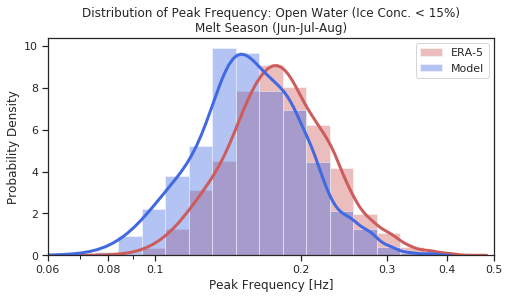

In [150]:
## grow season 10 11
## peak frequency: open water
## BEAUFORT REGION
setmin = 6e-2
setmax = 5e-1
hsmin = 0.2
nbins = 20
bins = np.logspace(np.log10(setmin),np.log10(setmax),nbins)

model_fp = vbeau_fp_0_melt#[vbeau_hs_0_grow > hsmin]
era5_fp = era5_fp_beau_np_melt ## beware this already has 0.2 min Hs 

with sns.axes_style('white'):
    fig,ax = plt.subplots(1,1,figsize=(8,4))

    minorticks()
    plt.subplot()
    ax1 = sns.distplot(era5_fp,bins=bins,kde=True,rug=False,
                       color='indianred',
                       label='ERA-5',
#                        hist_kws={'range':(setmin,setmax)},
                       kde_kws={'linewidth':3,'bw':0.01,
                                'label':'','clip':[setmin,setmax]})
    sns.distplot(model_fp,bins=bins,kde=True,
                 color='royalblue',
                 label='Model',
#                  hist_kws={'range':(setmin,setmax)},
                 kde_kws={'linewidth':3,'bw':.01,'label':'','clip':[setmin,setmax]},
                 ax=ax1)
    plt.title('Distribution of Peak Frequency: Open Water (Ice Conc. < 15%)\nMelt Season (Jun-Jul-Aug)')
    plt.ylabel('Probability Density')
    plt.xlabel('Peak Frequency [Hz]')
#     plt.xticks(np.linspace(0.4,1.0,4))
    plt.xlim(setmin,setmax)
    plt.legend()
    plt.xscale('log')
    plt.tick_params(axis='x', which='minor',labelsize=105)

    xticklab = np.round(np.append([0.06,0.08],np.arange(0.1,0.51,0.1)),2)
    plt.xticks(ticks=xticklab,labels=xticklab.astype(str))

    plt.show()

In [154]:
((era5native.pp1d)**(-1)).max()
(ww1719beau.fp).max()

<xarray.DataArray 'fp' ()>
array(390.43716431)

# Concentration bias: melt vs growth season

In [156]:
### month toggle ###
monmin = 9
monmax = 12

monmin = 5
monmax = 9
####################

## obs
tempice = boot.aice_d.sel(time=slice('2012-01-01','2019-12-31'))
tempice = tempice.where(
    (tempice.time.dt.month > monmin) & (tempice.time.dt.month < monmax), drop=True)
temp = tempice.sel(nj=latslice).where(beau_mask > 0, drop=True)

tempice = dist_sat_all.cdr.sel(time=slice('2012-01-01','2019-12-31'))
tempice = tempice.where(
    (tempice.time.dt.month > monmin) & (tempice.time.dt.month < monmax), drop=True)
dist_temp = tempice.where(beau_mask > 0, drop=True)

temp_obs = temp.where(dist_temp > 100)

## model
tempice = ww0019.ice.sel(time=slice('2012-01-01','2019-12-31'))
tempice = tempice.where(
    (tempice.time.dt.month > monmin) & (tempice.time.dt.month < monmax), drop=True)
temp = tempice.sel(nj=latslice).where(beau_mask > 0, drop=True)

tempice = dist_model.sel(time=slice('2012-01-01','2019-12-31'))
tempice = tempice.where(
    (tempice.time.dt.month > monmin) & (tempice.time.dt.month < monmax), drop=True)
dist_temp = tempice.where(beau_mask > 0, drop=True)

temp_model = temp.where(dist_temp > 100)

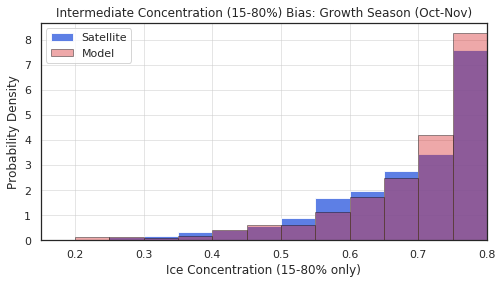

In [155]:
with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(8,4))
    temp_obs.plot(bins=np.arange(15,81,5)/100,density=True,
                  alpha=0.85,
                  color='royalblue',
                  edgecolor='w',
                  label='Satellite')
    temp_model.plot(bins=np.arange(15,81,5)/100,density=True,
                    alpha=0.4,
                    color='tab:red',
                    edgecolor='k',
                    label='Model')
    
    plt.xlim(0.15,0.80)
#     plt.ylim(0,5)
    plt.title('')
    plt.xlabel('Ice Concentration (15-80% only)')
    plt.ylabel('Probability Density')
    plt.title('Intermediate Concentration (15-80%) Bias: Growth Season (Oct-Nov)')
#     plt.title('Intermediate Concentration (15-80%) Bias: Melt Season (Jun-Jul-Aug)')
    ax.grid(True,alpha=0.5)
    plt.legend()
    plt.show()

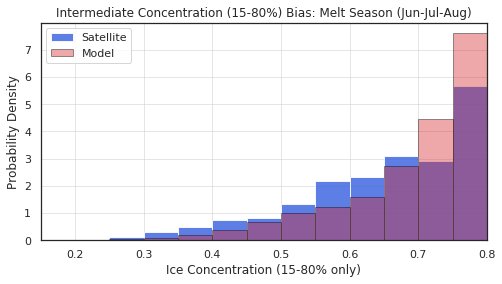

In [157]:
with sns.axes_style('white'):
    fig,ax = plt.subplots(figsize=(8,4))
    temp_obs.plot(bins=np.arange(15,81,5)/100,density=True,
                  alpha=0.85,
                  color='royalblue',
                  edgecolor='w',
                  label='Satellite')
    temp_model.plot(bins=np.arange(15,81,5)/100,density=True,
                    alpha=0.4,
                    color='tab:red',
                    edgecolor='k',
                    label='Model')
    
    plt.xlim(0.15,0.80)
#     plt.ylim(0,5)
    plt.title('')
    plt.xlabel('Ice Concentration (15-80% only)')
    plt.ylabel('Probability Density')
#     plt.title('Intermediate Concentration (15-80%) Bias: Growth Season (Oct-Nov)')
    plt.title('Intermediate Concentration (15-80%) Bias: Melt Season (Jun-Jul-Aug)')
    ax.grid(True,alpha=0.5)
    plt.legend()
    plt.show()

In [185]:
dist_model.sel(time='2019-08-28',nj=nj['sodaB']-300,ni=ni['sodaB'])[-1]

<xarray.DataArray ()>
array(199.06772, dtype=float32)
Coordinates:
    longitude  float32 214.273
    latitude   float32 75.405136
    time       datetime64[ns] 2019-08-28T18:00:00
    mask       bool True

### Identify concentrations of cells with wind waves in observations

In [107]:
conc_append = np.array([])
for key in insitu_dict.keys():
    if (key[0:2] != 'SW'):  
        dist,conc,hs = get_dist_conc_hs('cdr',key)
        conc_cat = conc[(dist > 100) & (hs > 0.2)]
        print(conc_cat.size)
        conc_append = np.append(conc_append,conc_cat)

14
9
16
21
2


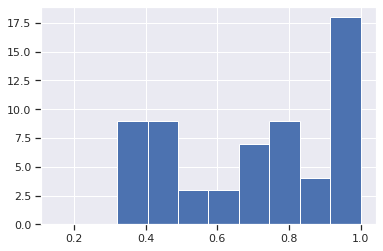

In [118]:
plt.hist(conc_append,range=[0.15,1])
plt.show()

## Get dates of wind waves at 100+ km

In [60]:
times = np.array([]).astype(np.datetime64)
keyslist = np.array([])
distmin = 100
distmax = 1e9
hsmin = 0.30

for key,val in insitu_dict.items():
        if (key[0:4] == 'bgos'):
            print(key)
#             val = val.sel(time=val.time.dt.month.isin(monlist))
            spectrum = val.wavespectra_energy.where(
                (val.cdr > distmin) & 
                (val.cdr < distmax) & 
#                 (val.time.dt.month.isin(monlist)) & 
                (val.sigwaveheight > hsmin))
        
            temptime = spectrum.max(dim='freq_wavespectra')
            temptime = temptime.where(temptime > 0,drop=True).time.values
            times = np.append(times,temptime)

            tempkey = np.tile(key,temptime.size)
            keyslist = np.append(keyslist,tempkey)

bgosA
bgosD


In [61]:
%%time
np.unique(np.sort(times))

CPU times: user 68 µs, sys: 7 µs, total: 75 µs
Wall time: 78.4 µs


array(['2016-06-30T00:00:00.000000000', '2016-07-15T18:00:00.000000000',
       '2016-07-16T00:00:00.000000000', '2016-07-16T06:00:00.000000000',
       '2016-07-16T12:00:00.000000000', '2016-07-16T18:00:00.000000000',
       '2016-07-17T06:00:00.000000000', '2016-07-17T12:00:00.000000000',
       '2016-07-17T18:00:00.000000000', '2016-07-19T00:00:00.000000000',
       '2016-07-19T06:00:00.000000000', '2016-07-19T12:00:00.000000000',
       '2016-07-19T18:00:00.000000000', '2016-07-20T00:00:00.000000000',
       '2016-07-20T06:00:00.000000000', '2016-07-20T12:00:00.000000000',
       '2016-07-21T00:00:00.000000000', '2016-08-01T12:00:00.000000000',
       '2018-07-20T00:00:00.000000000', '2018-07-20T06:00:00.000000000',
       '2018-07-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [62]:
pd.DataFrame({'time':times,'instrument':keyslist})

time instrument
0  2016-06-30 00:00:00      bgosA
1  2016-07-15 18:00:00      bgosA
2  2016-07-16 00:00:00      bgosA
3  2016-07-16 06:00:00      bgosA
4  2016-07-16 12:00:00      bgosA
5  2016-07-16 18:00:00      bgosA
6  2016-07-17 06:00:00      bgosA
7  2016-07-17 12:00:00      bgosA
8  2016-07-17 18:00:00      bgosA
9  2016-07-19 00:00:00      bgosA
10 2016-07-19 06:00:00      bgosA
11 2016-07-19 12:00:00      bgosA
12 2016-07-19 18:00:00      bgosA
13 2016-07-20 00:00:00      bgosA
14 2016-07-20 06:00:00      bgosA
15 2016-07-20 12:00:00      bgosA
16 2016-07-21 00:00:00      bgosA
17 2016-08-01 12:00:00      bgosA
18 2018-07-20 00:00:00      bgosA
19 2018-07-20 06:00:00      bgosA
20 2018-07-26 00:00:00      bgosA
21 2018-07-20 00:00:00      bgosD
22 2018-07-20 06:00:00      bgosD